### Update 14/11
##### Methods are based on https://github.com/Shitao-zz/Kaggle-House-Prices-Advanced-Regression-Techniques and this https://www.kaggle.com/niteshx2/top-50-beginners-stacking-lgb-xgb
- Add a new feature on [popular primary schools](https://www.moe.gov.sg/primary/p1-registration/distance) priority is given to people living < 2 km near these schools. Chosen primary schools are based on [oversubscribed rates](https://www.salary.sg/2022/best-primary-schools-2022-by-popularity/)
- - Secondary school is based on scores not based on living distance so we ignore.

Update Preprocessing
- - - Drop: Planning area variables cannot really explain. area_size(of planning area does not really explain), population(of planning area).
- - Dropping outliers, unimportant features, handle categorical features, log transform skewed variables.
- - Furnishing keep 3 values, Fully furnished, partially, unfurnished
- - 'region' there is 'geyland' value

Model Training
- - Random forest, xgboost, lightgbm. 
- - Level 1: StackingCVRegressor, 

FINAL Variables
- 'property_type', 'tenure', 'built_year', 'num_beds', 'num_baths',
       'furnishing', 'available_unit_types', 'total_num_units', 'cc_distance',
       'mrt_distance', 'shop_distance', 'population', 'log_size_sqft',
       'region', 'near_top_ps', 'secondary_school_distance'

### TO DO
- Explain that we are removing 'landed'. EDA need show why landed can skew data
- Explain why we need to normalise price, is because we want to achieve ['Homoscedasticity'](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python#5.-Getting-hard-core) 
- Double check distances calculation when merge with planning_area, serangoon planning area is way too big, might miss some places
- Remove single charts, summarise the code
- Markdown each section clearly (#, ##, ###)
- Standardise coding formats (variable names, function names)
- EDA do not do preprocessing. In EDA just note what kind of missing values and suggested replacement values. Move all preprocessing into the section 2. 
- - Do not drop any columns until the 2nd section

- - For each Numerical column we can apply log so that it will all have normal distribution so that it can correlate properly with log_price.

```
#histogram and normal probability plot
sns.distplot(train['price'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
```

- Create Table of contents
Suggested Table of Contents
1. EDA
2. Mining & Data Preprocessing
3. Modelling

##### Notes:
- Do not need to add inflation or housing price growth because these two variables are built into housing prices.
- What is total_num_units?

### 4 Statistical assumptions why we do any of the preprocessing or EDA
According to [Hair et al. (2013)](https://amzn.to/2uC3j9p), four assumptions should be tested:

Normality - When we talk about normality what we mean is that the data should look like a normal distribution. This is important because several statistic tests rely on this (e.g. t-statistics). In this exercise we'll just check univariate normality for 'SalePrice' (which is a limited approach). Remember that univariate normality doesn't ensure multivariate normality (which is what we would like to have), but it helps. Another detail to take into account is that in big samples (>200 observations) normality is not such an issue. However, if we solve normality, we avoid a lot of other problems (e.g. heteroscedacity) so that's the main reason why we are doing this analysis.

Homoscedasticity - I just hope I wrote it right. Homoscedasticity refers to the 'assumption that dependent variable(s) exhibit equal levels of variance across the range of predictor variable(s)' ([Hair et al. (2013)](https://amzn.to/2uC3j9p)). Homoscedasticity is desirable because we want the error term to be the same across all values of the independent variables.

Linearity- The most common way to assess linearity is to examine scatter plots and search for linear patterns. If patterns are not linear, it would be worthwhile to explore data transformations. However, we'll not get into this because most of the scatter plots we've seen appear to have linear relationships.

Absence of correlated errors - Correlated errors, like the definition suggests, happen when one error is correlated to another. For instance, if one positive error makes a negative error systematically, it means that there's a relationship between these variables. This occurs often in time series, where some patterns are time related. We'll also not get into this. However, if you detect something, try to add a variable that can explain the effect you're getting. That's the most common solution for correlated errors.

### Table of contents
* [EDA](#1)
* [Mining & Data Preprocessing](#2)
* [Modelling](#3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statistics as st 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.compose import make_column_selector
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
# import category_encoders as ce
import datetime

In [2]:
# !pip install mlxtend
from mlxtend.regressor import StackingCVRegressor

# EDA <a class="anchor" id="1"></a>

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### planning_area & subzone NA value in test dataset

In [4]:
train

,listing_id,title,address,property_name,property_type,tenure,built_year,num_beds,num_baths,size_sqft,...,furnishing,available_unit_types,total_num_units,property_details_url,lat,lng,elevation,subzone,planning_area,price
0,122881,hdb flat for sale in 866 yishun street 81,sembawang / yishun (d27),866 yishun street 81,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,...,unspecified,NaN,116.0,https://www.99.co/singapore/hdb/866-yishun-str...,1.414399,103.837196,0,yishun south,yishun,514500.0
1,259374,hdb flat for sale in 506b serangoon north aven...,hougang / punggol / sengkang (d19),hdb-serangoon estate,hdb,99-year leasehold,1992.0,4.0,2.0,1575,...,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,https://www.99.co/singapore/hdb/hdbserangoon-e...,1.372597,103.875625,0,serangoon north,serangoon,995400.0
2,665422,4 bed condo for sale in meyerhouse,128 meyer road,meyerhouse,condo,freehold,2022.0,4.0,6.0,3070,...,partial,"studio, 3, 4, 5, 6 br",56.0,https://www.99.co/singapore/condos-apartments/...,1.298773,103.895798,0,mountbatten,marine parade,8485000.0
3,857699,3 bed condo for sale in leedon green,26 leedon heights,leedon green,Condo,freehold,2023.0,3.0,2.0,958,...,partial,"studio, 1, 2, 3, 4 br",638.0,https://www.99.co/singapore/condos-apartments/...,1.312364,103.803271,0,farrer court,bukit timah,2626000.0
4,216061,2 bed condo for sale in one bernam,1 bernam street,one bernam,condo,99-year leasehold,2026.0,2.0,1.0,732,...,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,https://www.99.co/singapore/condos-apartments/...,1.273959,103.843635,0,anson,downtown core,1764000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20249,345066,2 bed condo for sale in lentor modern,lentor central,lentor modern,condo,99-year leasehold,2026.0,2.0,2.0,635,...,unspecified,"1, 2, 3, 4 br",605.0,https://www.99.co/singapore/condos-apartments/...,1.385938,103.834466,0,tagore,ang mo kio,1050000.0
20250,868680,2 bed condo for sale in mori,223 guillemard road,mori,Condo,freehold,2026.0,2.0,2.0,883,...,unspecified,"1, 2, 3, 4 br",137.0,https://www.99.co/singapore/condos-apartments/...,1.315948,103.857589,0,lavender,kallang,2087400.0
20251,928187,4 bed condo for sale in pullman residences newton,18 dunearn road,pullman residences newton,condo,freehold,2023.0,4.0,4.0,1378,...,unspecified,"studio, 1, 2, 3, 4, 5 br",340.0,https://www.99.co/singapore/condos-apartments/...,1.315961,103.836848,0,moulmein,novena,4193700.0
20252,135122,hdb flat for sale in 691d woodlands drive 73,admiralty / woodlands (d25),admiralty flora,hdb 5 rooms,99-year leasehold,2017.0,3.0,2.0,1205,...,unfurnished,"2, 3, 4 br",402.0,https://www.99.co/singapore/hdb/admiralty-flor...,1.440753,103.806671,0,woodlands east,woodlands,754800.0


In [5]:
len(train[train['built_year'] >= 2020])

8252

In [6]:
train['built_year'].nunique()

63

train['built_year']

In [7]:
emptyPA = test[test['planning_area'].isna()]
emptyPA['address'].unique()

array(['1 tessensohn road', '38 lorong 32 geylang', '17 farrer drive',
       '5 jalan mutiara'], dtype=object)

In [8]:
missingPA = pd.read_csv('auxiliary-data/missingPAdata.csv')
missingPA.head()

,address,planning_area,subzone
0,1 tessensohn road,kallang,boon keng
1,38 lorong 32 geylang,geyland,aljunied
2,15 farrer drive,tanglin,chatsworth
3,17 farrer drive,tanglin,chatsworth
4,5 jalan mutiara,tanglin,nassim


In [9]:
s = missingPA.set_index('address')['planning_area']
test['planning_area']=test['planning_area'].fillna(test['address'].map(s))

In [10]:
s = missingPA.set_index('address')['subzone']
test['subzone']=test['planning_area'].fillna(test['subzone'].map(s))

In [11]:
test.count()

listing_id              6966
title                   6966
address                 6964
property_name           6966
property_type           6966
tenure                  6329
built_year              6608
num_beds                6931
num_baths               6817
size_sqft               6966
floor_level             1156
furnishing              6966
available_unit_types    6446
total_num_units         5066
property_details_url    6966
lat                     6966
lng                     6966
elevation               6966
subzone                 6966
planning_area           6966
dtype: int64

#### planning & subzone in train dataset

In [12]:
data = train[train['planning_area'].isna()]
data['address'].unique()

array(['1 tessensohn road', '15 farrer drive', '17 farrer drive',
       '38 lorong 32 geylang', '5 jalan mutiara'], dtype=object)

In [13]:
s = missingPA.set_index('address')['planning_area']
train['planning_area']=train['planning_area'].fillna(train['address'].map(s))

In [14]:
s = missingPA.set_index('address')['subzone']
train['subzone']=train['planning_area'].fillna(train['subzone'].map(s))

#### landed property analysis

In [15]:
pt = train['property_type']
print(pt)
pt.unique()

0        hdb 4 rooms
1                hdb
2              condo
3              Condo
4              condo
            ...     
20249          condo
20250          Condo
20251          condo
20252    hdb 5 rooms
20253          condo
Name: property_type, Length: 20254, dtype: object


array(['hdb 4 rooms', 'hdb', 'condo', 'Condo', 'bungalow', 'Hdb',
       'terraced house', 'Hdb Executive', 'apartment',
       'Semi-Detached House', 'Apartment', 'Hdb 4 Rooms',
       'semi-detached house', 'hdb 3 rooms', 'executive condo',
       'corner terrace', 'hdb executive', 'Hdb 3 Rooms', 'Hdb 5 Rooms',
       'hdb 5 rooms', 'landed', 'hdb 2 rooms', 'Executive Condo',
       'Bungalow', 'Corner Terrace', 'Terraced House', 'cluster house',
       'Cluster House', 'Land Only', 'townhouse', 'Hdb 2 Rooms',
       'conservation house', 'land only', 'walk-up', 'Townhouse',
       'Conservation House', 'good class bungalow', 'Landed', 'shophouse'],
      dtype=object)

In [16]:
pt.value_counts()

condo                  7905
hdb                    2288
Condo                  1743
hdb 3 rooms             961
hdb 4 rooms             947
semi-detached house     851
executive condo         820
bungalow                620
hdb 5 rooms             565
Hdb                     509
apartment               439
terraced house          363
hdb executive           243
Hdb 3 Rooms             232
corner terrace          209
Executive Condo         190
hdb 2 rooms             187
Hdb 4 Rooms             177
Semi-Detached House     167
cluster house           153
Bungalow                127
Hdb 5 Rooms             114
Apartment               101
Terraced House           83
Hdb Executive            62
Hdb 2 Rooms              47
Corner Terrace           46
Cluster House            31
landed                   17
walk-up                  16
conservation house       15
townhouse                 6
Conservation House        6
good class bungalow       5
Townhouse                 3
Landed              

<AxesSubplot:xlabel='count', ylabel='property_type'>

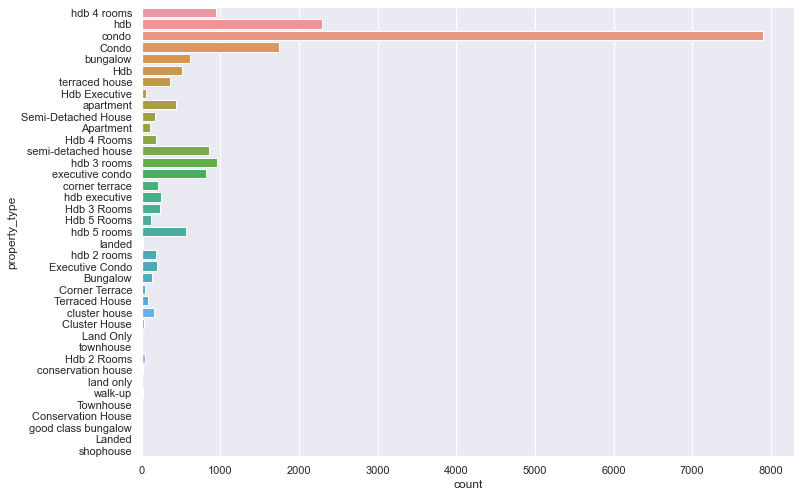

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(y='property_type',data=train)

Most trade property type is HDB and Condo, the landed property only occupy a small proportion. Almost none of the landed property have more than 100 trades. And, there are too many categories of landed property and the relation of these categories may cause confusion. So we decided to remove landed property.

## Pre-processing 
##### Preparing the data to be processed effectively

### Removing "listing_id" from columns
##### The unique identifiers for each of the data are not needed

In [18]:
train = train.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])
test = test.drop(columns=['listing_id', 'property_details_url', 'elevation','property_name','address','title'])

# train = train.drop(columns=['property_details_url', 'elevation','property_name','address','title'])

In [19]:
train.describe()

,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,price
count,19332.000000,20174.000000,19820.000000,2.025400e+04,14602.000000,20254.000000,20254.000000,2.025400e+04
mean,2010.833695,3.122931,2.643542,1.854364e+03,376.253938,1.434282,103.855356,5.228263e+06
std,15.822803,1.281658,1.473835,1.354343e+04,346.882474,1.558472,3.593441,2.779748e+08
min,1963.000000,1.000000,1.000000,0.000000e+00,4.000000,1.239621,-77.065364,0.000000e+00
25%,2000.000000,2.000000,2.000000,8.070000e+02,106.000000,1.307329,103.806576,8.190000e+05
50%,2017.000000,3.000000,2.000000,1.119000e+03,296.000000,1.329266,103.841552,1.680000e+06
75%,2023.000000,4.000000,3.000000,1.528000e+03,561.000000,1.372461,103.881514,3.242400e+06
max,2028.000000,10.000000,10.000000,1.496000e+06,2612.000000,69.486768,121.023232,3.924243e+10


## Additional Data
##### Additional Data not in the train and test dataset which needs to be processed

### Distances to different infrastructures

##### Accessibility to various areas or services (e.g., shopping malls) play a role in determining the housing prices, distances to these infrastructures are added to the dataset

#### Distance to commericial centres

In [20]:
ccdistance = pd.read_csv('auxiliary-data/sg-commerical-centres.csv')

In [21]:
# vectorized haversine function
#https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


In [22]:
# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(train, ccdistance, on = 'planning_area')
expected_result.head()
train['cc_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# train['cc_distance'] = haversine_np(train['lng'], train['lat'], ccdistance['lng'], ccdistance['lat'])
expected_result = pd.merge(test, ccdistance, on = 'planning_area')
expected_result.head()
test['cc_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [23]:
ccdistancemean = train['cc_distance'].median()
train['cc_distance']=train['cc_distance'].fillna(ccdistancemean)

ccdistancemean = test['cc_distance'].median()
test['cc_distance']=test['cc_distance'].fillna(ccdistancemean)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cc_distance'>

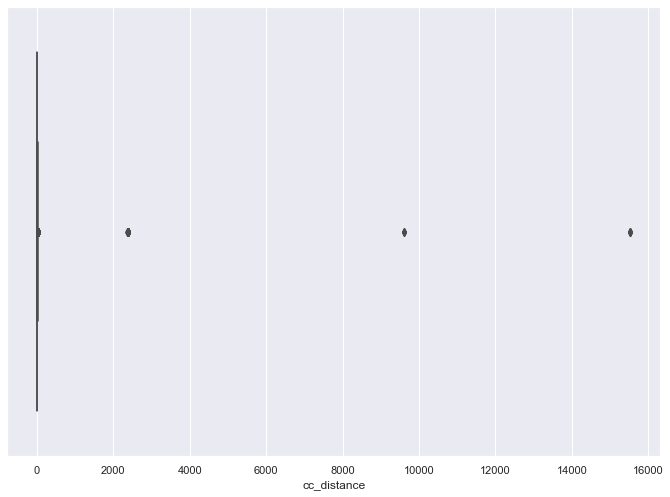

In [24]:
# Creating plot
sns.boxplot(train['cc_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cc_distance'>

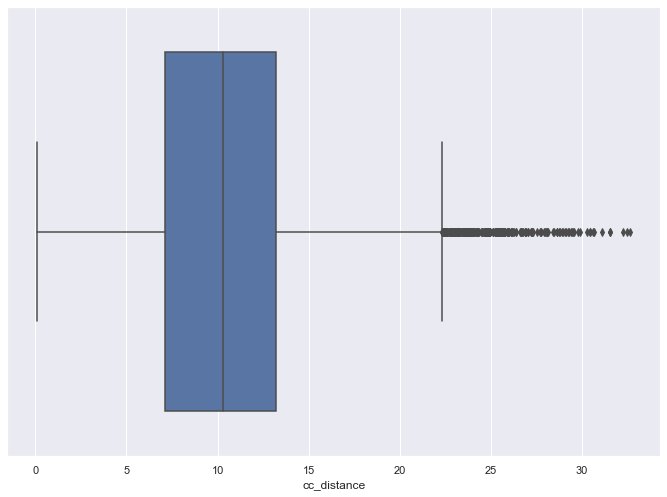

In [25]:
train.loc[train['cc_distance'] > 2000, 'cc_distance'] = train['cc_distance'].median()
# Creating plot
sns.boxplot(train['cc_distance'])


/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cc_distance'>

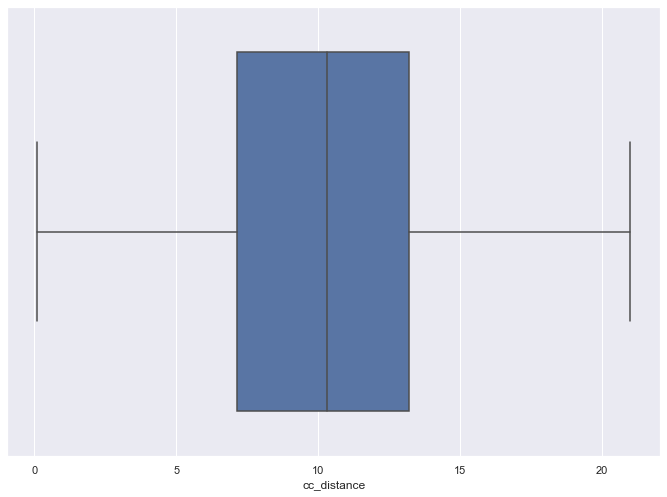

In [26]:
train.loc[train['cc_distance'] > 21, 'cc_distance'] = 21
# Creating plot
sns.boxplot(train['cc_distance'])


In [27]:
test.loc[test['cc_distance'] > 21, 'cc_distance'] = 21

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='cc_distance'>

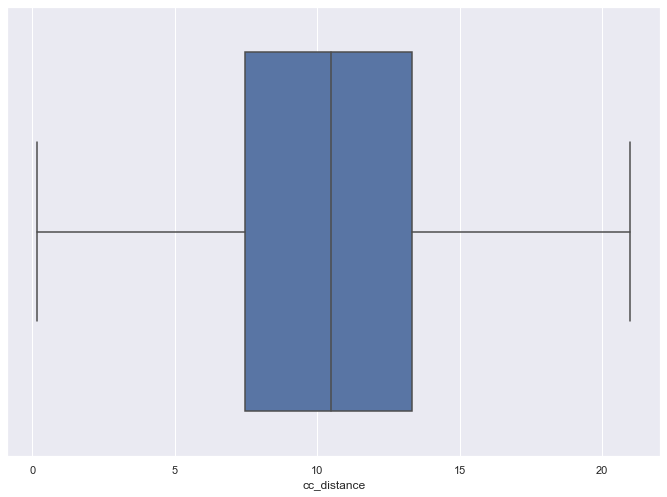

In [28]:
sns.boxplot(test['cc_distance'])

#### Distance to MRT stations

In [29]:
# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(train, mrtdistance, on = 'planning_area')
train['mrt_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])


# using long and lat
mrtdistance = pd.read_csv('auxiliary-data/sg-mrt-stations.csv')
expected_result = pd.merge(test, mrtdistance, on = 'planning_area')
test['mrt_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [30]:
mrtdistancemedian = train['mrt_distance'].median()
train['mrt_distance']=train['mrt_distance'].fillna(mrtdistancemedian)

mrtdistancemedian = test['mrt_distance'].median()
test['mrt_distance']=test['mrt_distance'].fillna(mrtdistancemedian)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mrt_distance'>

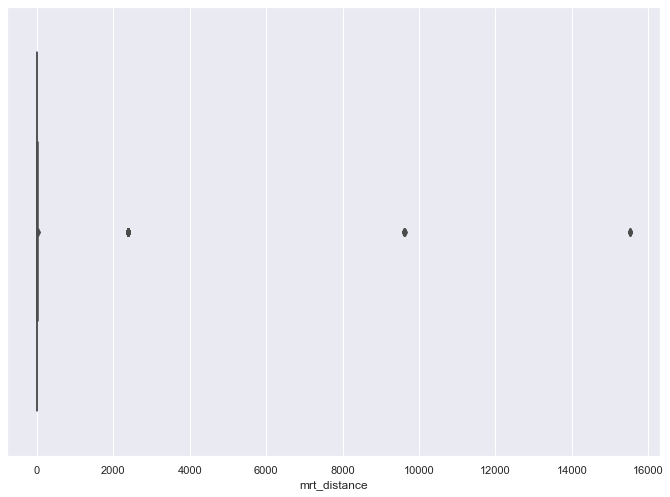

In [31]:
sns.boxplot(train['mrt_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mrt_distance'>

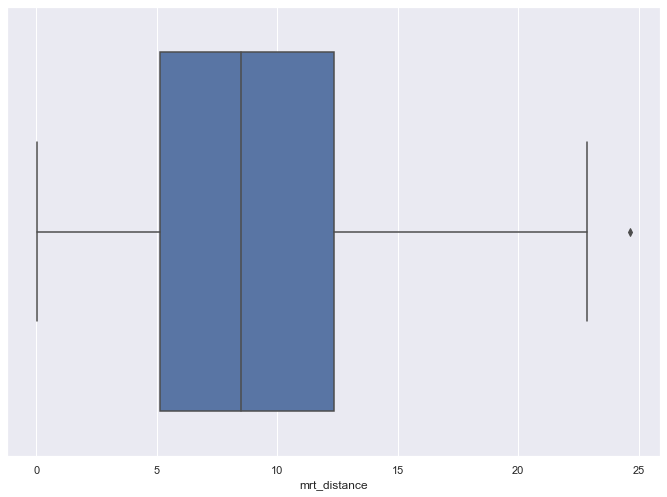

In [32]:
train.loc[train['mrt_distance'] > 2000, 'mrt_distance'] = train['mrt_distance'].median()
# Creating plot
sns.boxplot(train['mrt_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mrt_distance'>

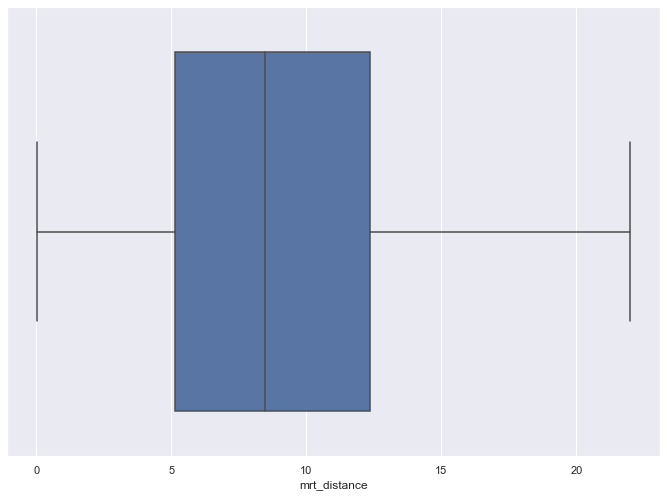

In [33]:
train.loc[train['mrt_distance'] > 22, 'mrt_distance'] = 22
# Creating plot
sns.boxplot(train['mrt_distance'])

In [34]:
test.loc[test['mrt_distance'] > 2000, 'mrt_distance'] = test['mrt_distance'].median()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mrt_distance'>

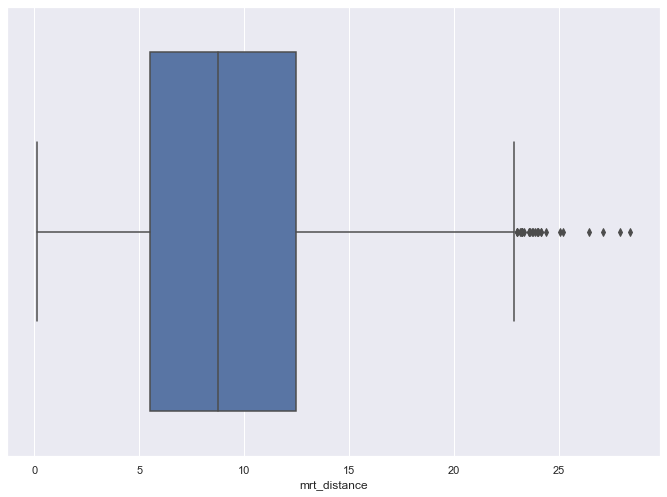

In [35]:
sns.boxplot(test['mrt_distance'])

#### Distance to primary schools

In [36]:
# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(train, primaryschooldistance, on = 'planning_area')
train['primary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
primaryschooldistance = pd.read_csv('auxiliary-data/sg-primary-schools.csv')
expected_result = pd.merge(test, primaryschooldistance, on = 'planning_area')
test['primary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [37]:
pschoolmedian = train['primary_school_distance'].median()
train['primary_school_distance'] = train['primary_school_distance'].fillna(pschoolmedian)

pschoolmedian = test['primary_school_distance'].median()
test['primary_school_distance'] = test['primary_school_distance'].fillna(pschoolmedian)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='primary_school_distance'>

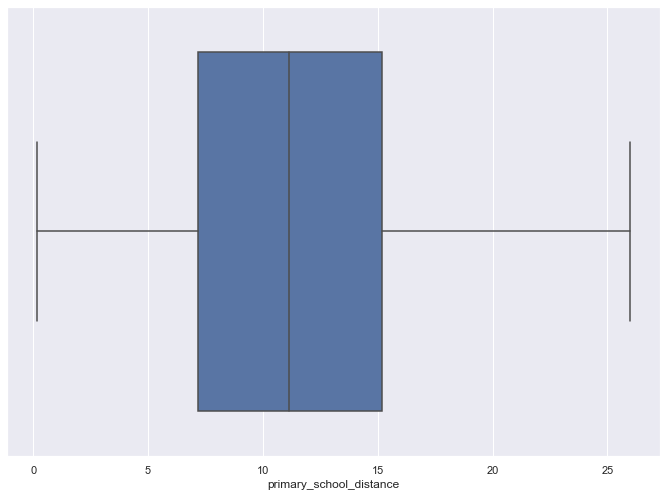

In [38]:
train.loc[train['primary_school_distance'] > 26, 'primary_school_distance'] = 26
sns.boxplot(train['primary_school_distance'])

In [39]:
test.loc[test['primary_school_distance'] > 26, 'primary_school_distance'] = 26

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='primary_school_distance'>

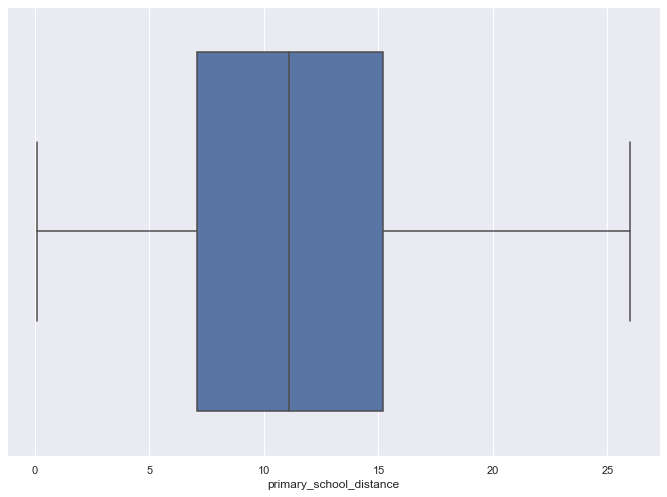

In [40]:
sns.boxplot(test['primary_school_distance'])

#### Distance to secondary schools

In [41]:
# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['secondary_school_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
secschooldistance = pd.read_csv('auxiliary-data/sg-secondary-schools.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['secondary_school_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [42]:
sschooldistance = train['secondary_school_distance'].median()
train['secondary_school_distance'] = train['secondary_school_distance'].fillna(sschooldistance)

sschooldistance = test['secondary_school_distance'].median()
test['secondary_school_distance'] = test['secondary_school_distance'].fillna(sschooldistance)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='secondary_school_distance'>

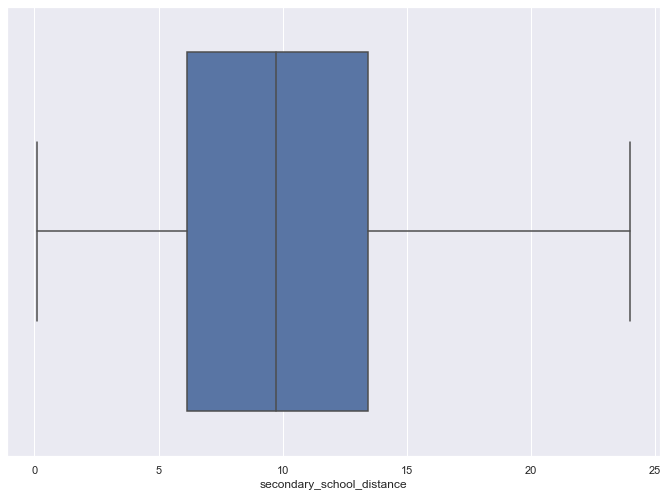

In [43]:
train.loc[train['secondary_school_distance'] > 24, 'secondary_school_distance'] = 24
sns.boxplot(train['secondary_school_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='secondary_school_distance'>

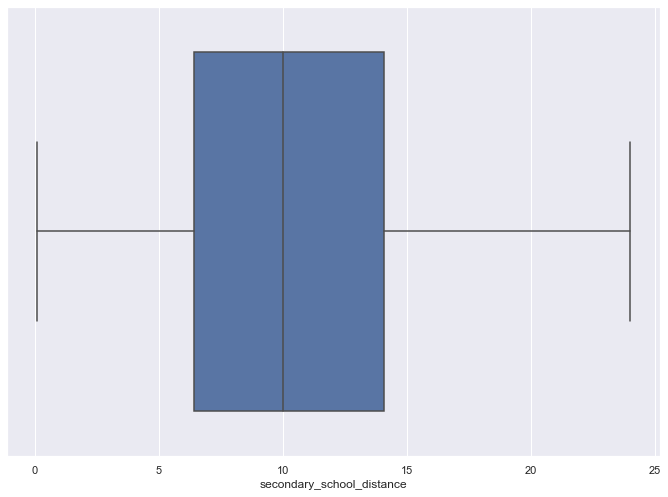

In [44]:
test.loc[test['secondary_school_distance'] > 24, 'secondary_school_distance'] = 24
sns.boxplot(test['secondary_school_distance'])

#### Distance to shopping malls

In [45]:
# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(train, secschooldistance, on = 'planning_area')
train['shop_distance'] = haversine_np(train['lng'], train['lat'], expected_result['lng_y'], expected_result['lat_y'])

# using long and lat
shop_distance = pd.read_csv('auxiliary-data/sg-shopping-malls.csv')
expected_result = pd.merge(test, secschooldistance, on = 'planning_area')
test['shop_distance'] = haversine_np(test['lng'], test['lat'], expected_result['lng_y'], expected_result['lat_y'])

In [46]:
sdistancemedian = train['shop_distance'].median()
train['shop_distance'] = train['shop_distance'].fillna(sdistancemedian)

sdistancemedian = test['shop_distance'].median()
test['shop_distance'] = test['shop_distance'].fillna(sdistancemedian)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='shop_distance'>

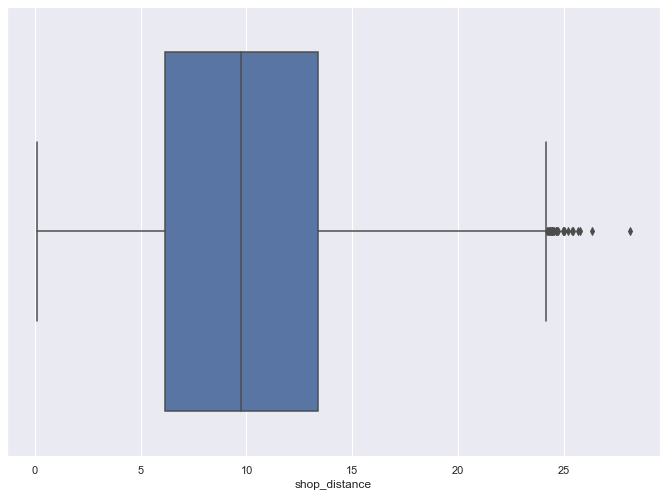

In [47]:
train.loc[train['shop_distance'] > 2000, 'shop_distance'] = train['shop_distance'].median()
sns.boxplot(train['shop_distance'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='shop_distance'>

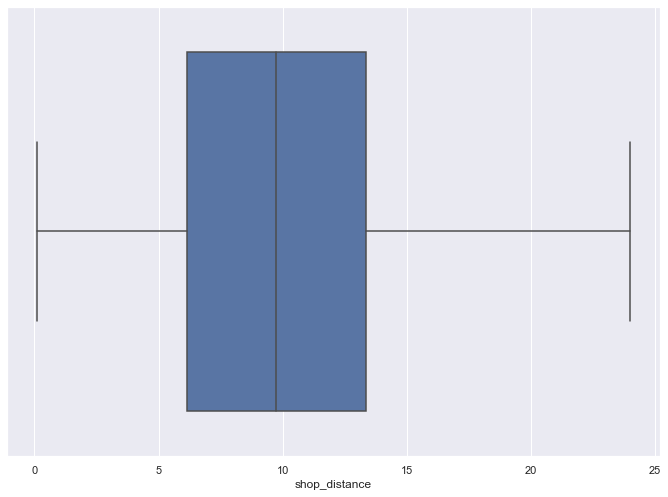

In [48]:
train.loc[train['shop_distance'] > 24, 'shop_distance'] = 24
sns.boxplot(train['shop_distance'])

In [49]:
test.loc[test['shop_distance'] > 24, 'shop_distance'] = 24

### lng & lat

In [50]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,lat,lng,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance
0,hdb 4 rooms,NaN,1988.0,3.0,2.0,1115,NaN,unspecified,NaN,116.0,1.414399,103.837196,yishun,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065
1,hdb,99-year leasehold,1992.0,4.0,2.0,1575,NaN,unspecified,"1, 2, 3, 4, 5, 6 br",NaN,1.372597,103.875625,serangoon,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202
2,condo,freehold,2022.0,4.0,6.0,3070,low,partial,"studio, 3, 4, 5, 6 br",56.0,1.298773,103.895798,marine parade,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137
3,Condo,freehold,2023.0,3.0,2.0,958,NaN,partial,"studio, 1, 2, 3, 4 br",638.0,1.312364,103.803271,bukit timah,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660
4,condo,99-year leasehold,2026.0,2.0,1.0,732,NaN,unspecified,"studio, 1, 2, 3, 4, 5 br",351.0,1.273959,103.843635,downtown core,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600


### Population

In [51]:
population = pd.read_csv('auxiliary-data/sg-subzones.csv')

In [52]:
expected_result = pd.merge(train, population, on = 'planning_area')
train['population'] = expected_result['population']
train['area_size'] = expected_result['area_size']

In [53]:
expected_result = pd.merge(test, population, on = 'planning_area')
test['population'] = expected_result['population']
test['area_size'] = expected_result['area_size']

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='population'>

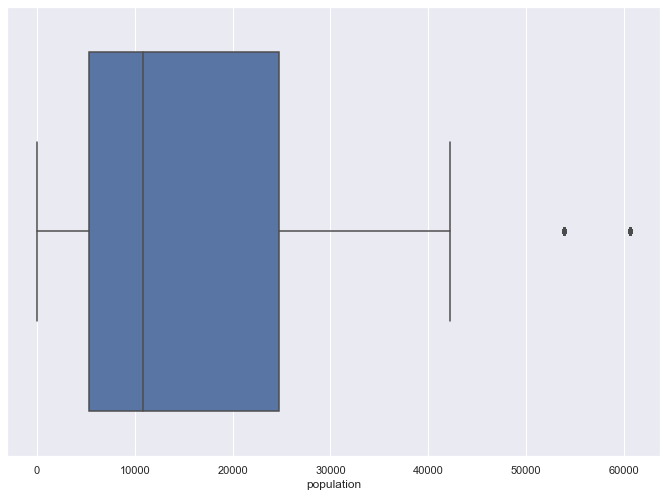

In [54]:
sns.boxplot(train['population'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='population'>

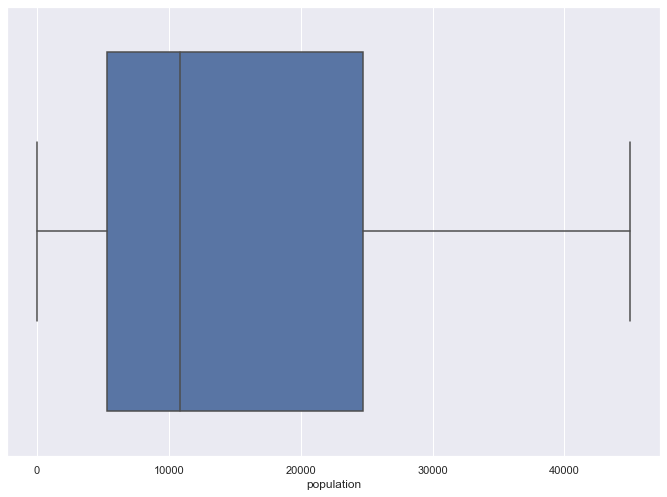

In [55]:
train.loc[train['population'] > 45000, 'population'] = 45000
sns.boxplot(train['population'])

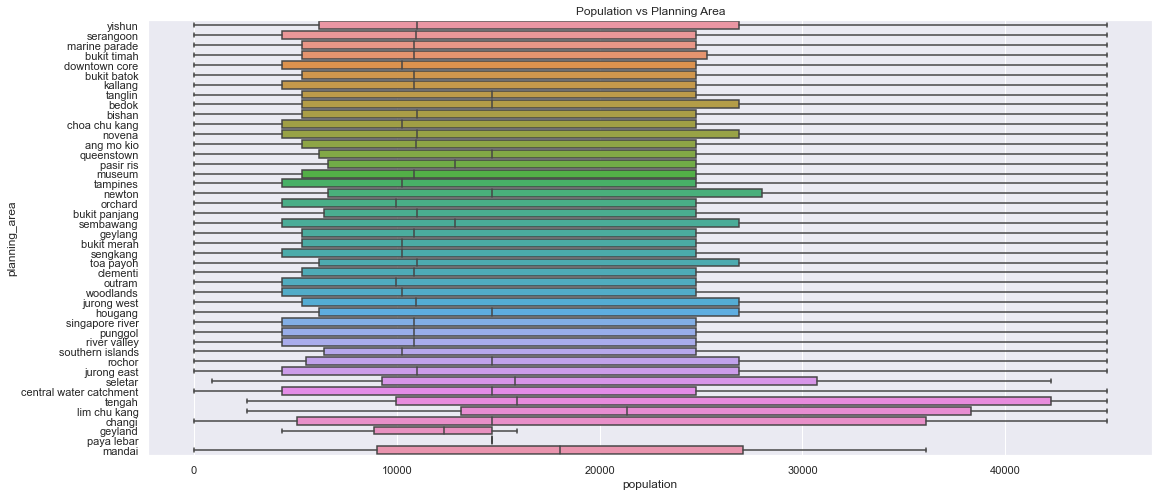

In [56]:
fig, axes = plt.subplots(figsize=(18,8))
sns.boxplot(x ='population', y= 'planning_area', data=train)
axes.set_title('Population vs Planning Area')
plt.show()

### Area_Size

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='area_size'>

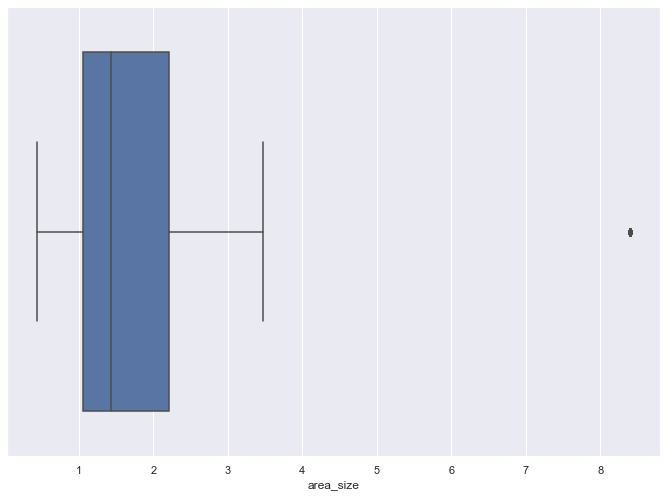

In [57]:
sns.boxplot(train['area_size'])

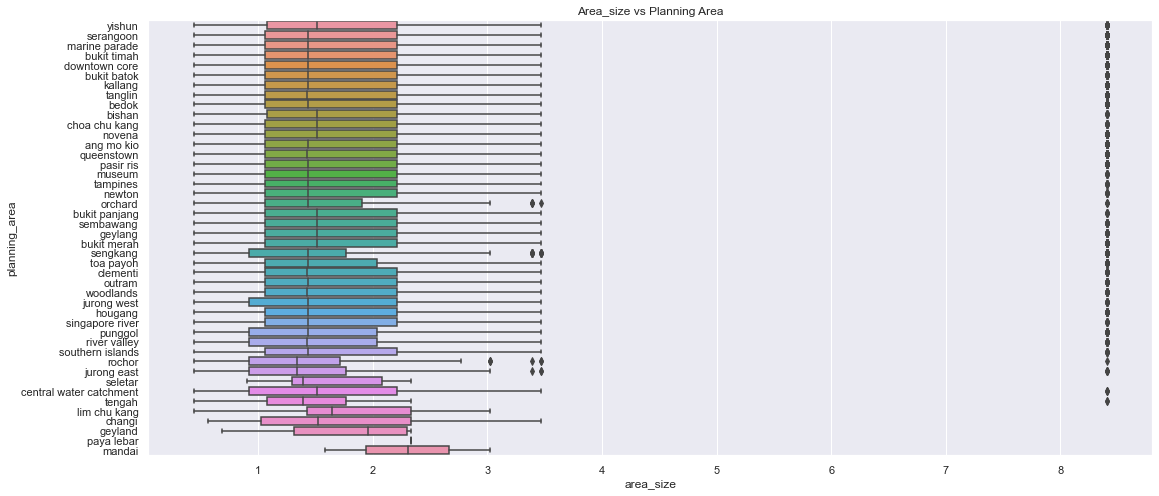

In [58]:
fig, axes = plt.subplots(figsize=(18,8))
sns.boxplot(x ='area_size', y= 'planning_area', data=train)
axes.set_title('Area_size vs Planning Area')
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='area_size'>

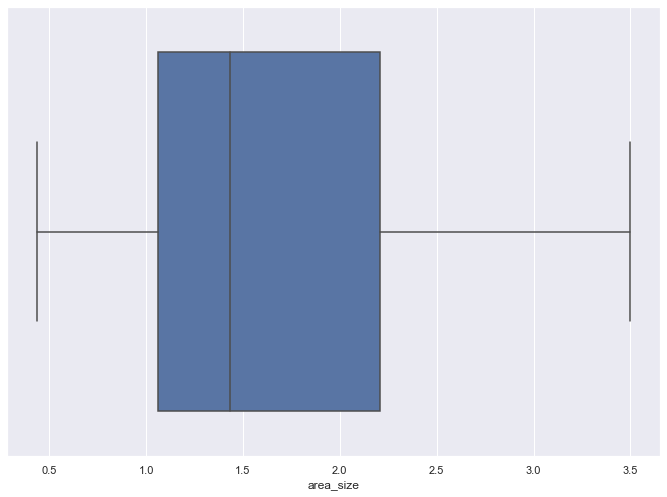

In [59]:
train.loc[train['area_size'] > 3.5, 'area_size'] = 3.5
sns.boxplot(train['area_size'])

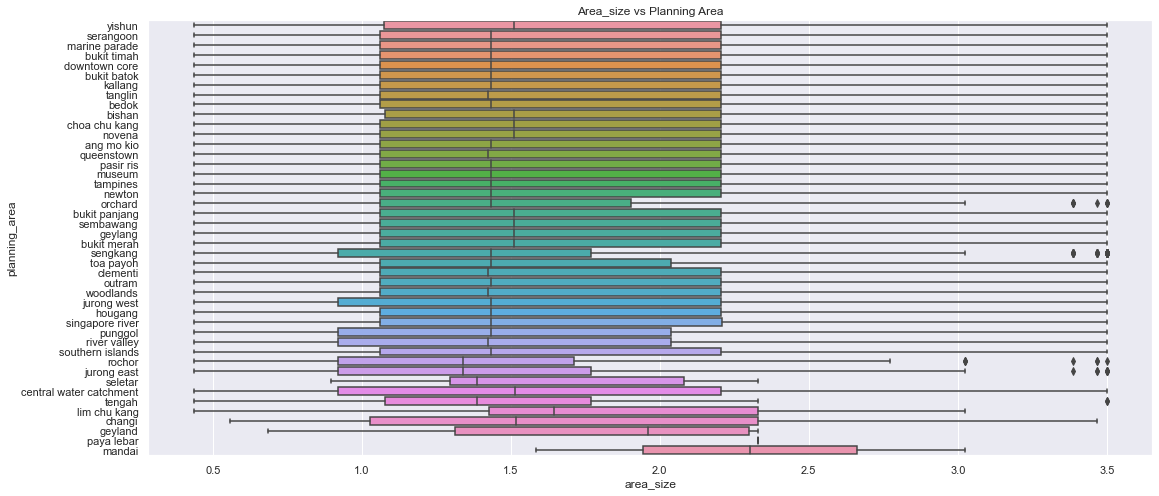

In [60]:
fig, axes = plt.subplots(figsize=(18,8))
sns.boxplot(x ='area_size', y= 'planning_area', data=train)
axes.set_title('Area_size vs Planning Area')
plt.show()

### Property Type cleaning

In [61]:
#Change all to uppercase
train['property_type']=train['property_type'].str.upper()

#Change all to uppercase
test['property_type']=test['property_type'].str.upper()

In [62]:
property_to_keep = test['property_type'].unique()
train.property_type.isin(property_to_keep)

train[~train.property_type.isin(property_to_keep)]

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,floor_level,furnishing,available_unit_types,total_num_units,...,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
635,LAND ONLY,freehold,2000.0,3.0,3.0,107,NaN,unspecified,"3, 4, 5, 6 br",12.0,...,tanglin,tanglin,101640000.0,7.065196,9.126171,10.128764,12.080913,12.080913,2620,0.4364
1575,LAND ONLY,99-year leasehold,NaN,5.0,5.0,5726,NaN,unfurnished,"3, 4, 5, 6 br",NaN,...,bukit panjang,bukit panjang,1257900.0,12.424904,10.844287,14.961924,11.324306,11.324306,10250,1.4329
19090,SHOPHOUSE,freehold,2019.0,2.0,2.0,657,NaN,unspecified,"1, 2 br",17.0,...,outram,outram,1621100.0,10.324064,1.401878,13.072322,13.021354,13.021354,6440,2.0385


In [63]:
categories_not_in_test = ['LAND ONLY', 'SHOPHOUSE']
train = train[train['property_type'].isin(categories_not_in_test) == False] 

In [64]:
train['property_type'] = train['property_type'].replace(
    ['CLUSTER HOUSE', 'CONSERVATION HOUSE', 'LANDED', 'WALK-UP', 'TOWNHOUSE', 'GOOD CLASS BUNGALOW', 'CORNER TERRACE', 'SEMI-DETACHED HOUSE', 'BUNGALOW', 'TERRACED HOUSE'],
    'LANDED'
)

test['property_type'] = test['property_type'].replace(
    ['CLUSTER HOUSE', 'CONSERVATION HOUSE', 'LANDED', 'WALK-UP', 'TOWNHOUSE', 'GOOD CLASS BUNGALOW', 'CORNER TERRACE', 'SEMI-DETACHED HOUSE', 'BUNGALOW', 'TERRACED HOUSE'],
    'LANDED'
)

In [65]:
train['property_type'] = train['property_type'].replace(
    ['HDB 3 ROOMS', 'HDB 4 ROOMS', 'HDB 5 ROOMS', 'HDB EXECUTIVE', 'HDB 2 ROOMS', 'APARTMENT'],
    'HDB'
)

test['property_type'] = test['property_type'].replace(
    ['HDB 3 ROOMS', 'HDB 4 ROOMS', 'HDB 5 ROOMS', 'HDB EXECUTIVE', 'HDB 2 ROOMS', 'APARTMENT'],
    'HDB'
)

In [66]:
train['property_type'] = train['property_type'].replace(
    ['EXECUTIVE CONDO'],
    'CONDO'
)

test['property_type'] = test['property_type'].replace(
    ['EXECUTIVE CONDO'],
    'CONDO'
)

In [67]:
#for regression only
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(train['property_type'])
# train['property_type']=le.transform(train['property_type'])

# test['property_type']=le.transform(test['property_type'])

# one hot endcoding
# pd.get_dummies(train.property_type, prefix='property')

## Features that are related to living conditions
##### Factors that buyers consider to be important to a good living standard corrolate with propety prices. 
##### tenure, furnishing, floor_level, total_num_units, built_year, num_baths, num_beds, available_unit_types
##### 


### tenure 
##### Tenure of the property (e.g., "freehold", "99-year leasehold") 

In [68]:
train['tenure'] = train['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

train['tenure'] = train['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    '999-year leasehold'
    ],
    'freehold'
)



test['tenure'] = test['tenure'].replace(
    [
    '99-year leasehold',
    '110-year leasehold',
    '103-year leasehold',
    '102-year leasehold',
    '100-year leasehold',
    ],
    '99-year leasehold'
)

test['tenure'] = test['tenure'].replace(
    [
    '946-year leasehold',
    '999-year leasehold',
    '956-year leasehold',
    '929-year leasehold',
    '947-year leasehold',
    '999-year leasehold',
    ],
    'freehold'
)

In [69]:
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [70]:
train['tenure'] = train['tenure'].fillna('99-year leasehold')

In [71]:
## Remove NA 
train = train.dropna(subset=['tenure'])

## Remove NA 
test['tenure'] = test['tenure'].fillna('99-year leasehold')

In [72]:
#for regression only

# from sklearn import preprocessing
# tenurepp = preprocessing.LabelEncoder()
# tenurepp.fit(train['tenure'])
# train['tenure']=tenurepp.transform(train['tenure'])

# test['tenure']=tenurepp.transform(test['tenure'])

### furnishing
##### Information whether the property is furnished (e.g., "fully", "partial")

In [73]:
#Assume not specified and na as unfurnished 
train['furnishing'] = train['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

#Assume not specified and na as unfurnished 
test['furnishing'] = test['furnishing'].replace(
    [
    'na',
    'unspecified',
    ],
    'unfurnished'
)

In [74]:
# #Assume not specified and na as unfurnished 
# train['furnishing'] = train['furnishing'].replace(
#     [
#     'fully',
#     ],
#     'partial'
# )

# #Assume not specified and na as unfurnished 
# test['furnishing'] = test['furnishing'].replace(
#     [
#     'fully',
#     ],
#     'partial'
# )

In [75]:
#for regression only

# from sklearn import preprocessing
# furnishing = preprocessing.LabelEncoder()
# furnishing.fit(train['furnishing'])
# train['furnishing']=furnishing.transform(train['furnishing'])

# test['furnishing']=furnishing.transform(test['furnishing'])

### floor_level
##### Information about the floor level of the property (e.g., "high", "low"). 

In [76]:
# Too few data for floor level, we should just take out the column
train = train.drop(columns='floor_level')

# Too few data for floor level, we should just take out the column
test = test.drop(columns='floor_level')

### total_num_units
##### Total number of units in the property complex

In [77]:
mediantotalunit = train['total_num_units'].median()
train['total_num_units'].fillna(mediantotalunit, inplace=True)

mediantotalunit = test['total_num_units'].median()
test['total_num_units'].fillna(mediantotalunit, inplace=True)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_num_units'>

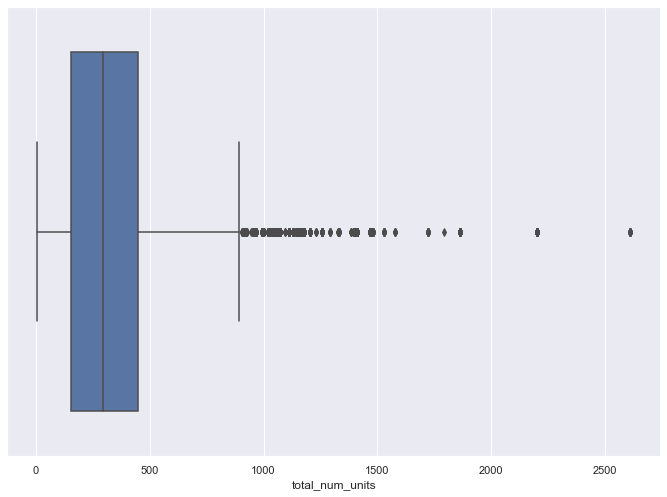

In [78]:
sns.boxplot(train['total_num_units'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_num_units'>

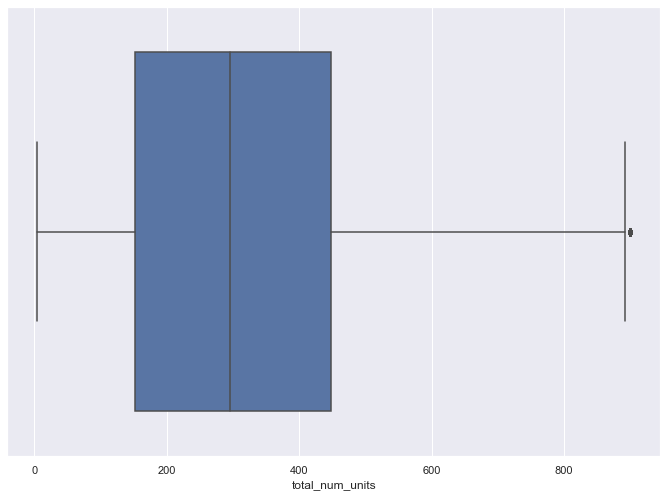

In [79]:
train.loc[train['total_num_units'] > 900, 'total_num_units'] = 900
# Creating plot
sns.boxplot(train['total_num_units'])

In [80]:
test.loc[test['total_num_units'] > 900, 'total_num_units'] = 900

In [81]:
train.count()

property_type                20251
tenure                       20251
built_year                   19330
num_beds                     20171
num_baths                    19817
size_sqft                    20251
furnishing                   20251
available_unit_types         18810
total_num_units              20251
lat                          20251
lng                          20251
subzone                      20251
planning_area                20251
price                        20251
cc_distance                  20251
mrt_distance                 20251
primary_school_distance      20251
secondary_school_distance    20251
shop_distance                20251
population                   20251
area_size                    20251
dtype: int64

### built_year
##### The year when the property was built.

In [82]:
train.count()

property_type                20251
tenure                       20251
built_year                   19330
num_beds                     20171
num_baths                    19817
size_sqft                    20251
furnishing                   20251
available_unit_types         18810
total_num_units              20251
lat                          20251
lng                          20251
subzone                      20251
planning_area                20251
price                        20251
cc_distance                  20251
mrt_distance                 20251
primary_school_distance      20251
secondary_school_distance    20251
shop_distance                20251
population                   20251
area_size                    20251
dtype: int64

In [83]:
train['built_year'].isnull().sum() / train['built_year'].sum()


2.369472061557495e-05

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='built_year'>

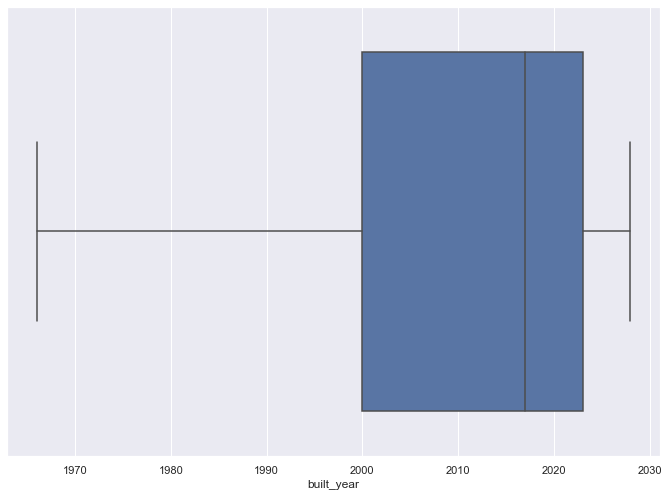

In [84]:
train.loc[train['built_year'] < 1966, 'built_year'] = 1966
sns.boxplot(train['built_year'])

In [85]:
avgbuildyear = round(train['built_year'].median(),0)
train['built_year'] = train['built_year'].fillna(avgbuildyear)

avgbuildyear = round(test['built_year'].median(),0)
test['built_year'] = test['built_year'].fillna(avgbuildyear)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='built_year'>

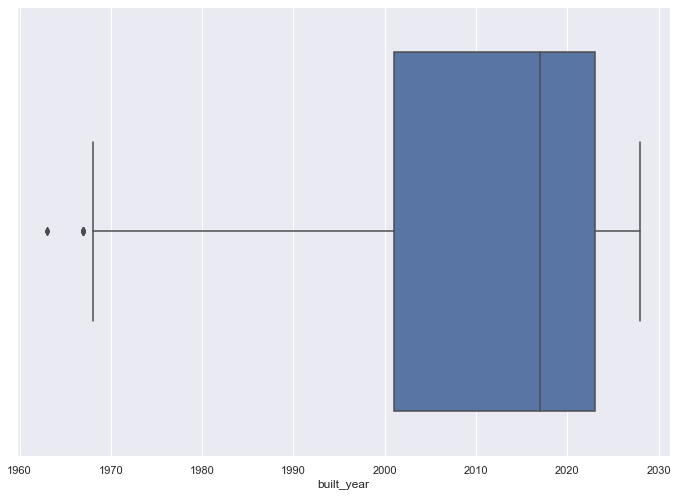

In [86]:
sns.boxplot(test['built_year'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='built_year'>

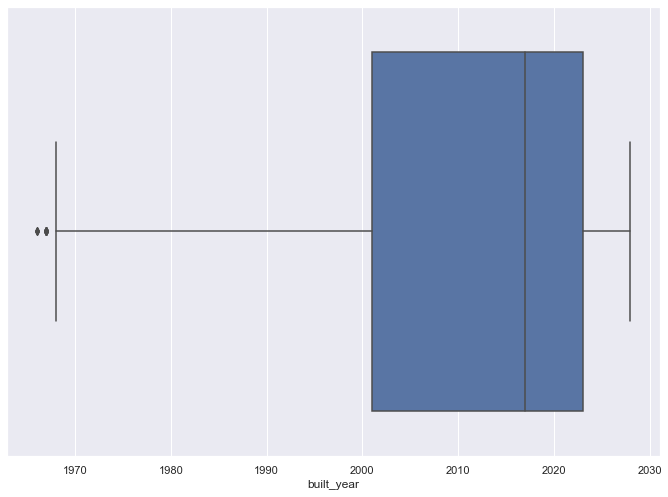

In [87]:
test.loc[test['built_year'] < 1966, 'built_year'] = 1966
sns.boxplot(test['built_year'])

### num_baths
##### Number of baths (i.e., washrooms)
##### A higher number of baths in a propety is usually more desirable.

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_baths'>

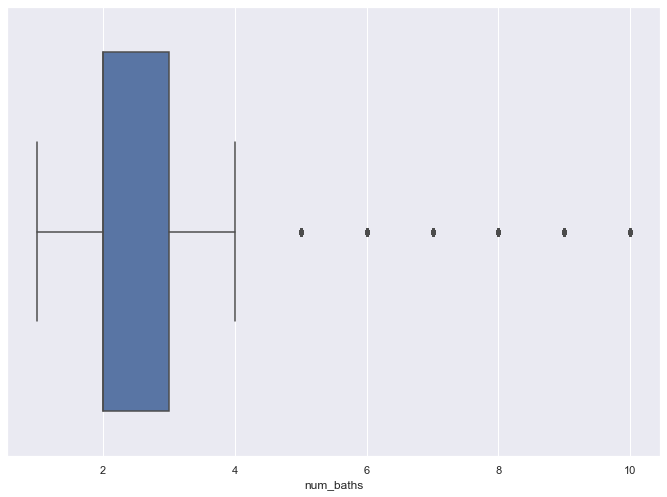

In [88]:
sns.boxplot(train['num_baths'])

In [89]:
a = train[train['num_baths'].isna()]
a[a['num_beds'].isna()]

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,...,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
3713,LANDED,freehold,1990.0,NaN,NaN,9594,unfurnished,"studio, 1, 4, 5, 6, 7 br",296.0,1.319714,...,novena,novena,16275000.0,5.668353,5.872226,6.905858,11.134265,11.134265,2620,0.4364
4691,CONDO,99-year leasehold,2023.0,NaN,NaN,431,unfurnished,"studio, 1, 2, 3, 4, 5, 8 br",774.0,1.283016,...,outram,outram,1222200.0,5.825357,8.355056,11.798265,15.372730,15.372730,890,2.2068
4939,HDB,99-year leasehold,1980.0,NaN,NaN,731,unfurnished,NaN,112.0,1.331612,...,bedok,bedok,367500.0,15.229001,7.025831,8.583307,13.354867,13.354867,42240,1.3402
5002,HDB,99-year leasehold,2004.0,NaN,NaN,1184,unfurnished,NaN,90.0,1.403418,...,punggol,punggol,669900.0,16.664632,6.751215,7.404180,7.477411,7.477411,42240,1.3402
11500,HDB,99-year leasehold,1985.0,NaN,NaN,786,unfurnished,"studio, 2, 3, 4 br",296.0,1.349904,...,bukit batok,bukit batok,409500.0,8.707527,4.914059,6.279880,18.454836,18.454836,24760,1.0619


In [90]:
avgbath = train['num_baths'].median()
train['num_baths'] = train['num_baths'].fillna(avgbath)

avgbath = test['num_baths'].median()
test['num_baths'] = test['num_baths'].fillna(avgbath)

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_baths'>

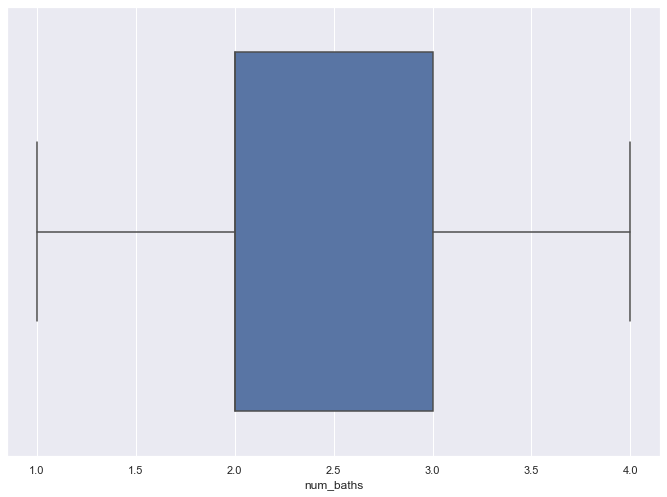

In [91]:
train.loc[train['num_baths'] > 4, 'num_baths'] = 4
sns.boxplot(train['num_baths'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_baths'>

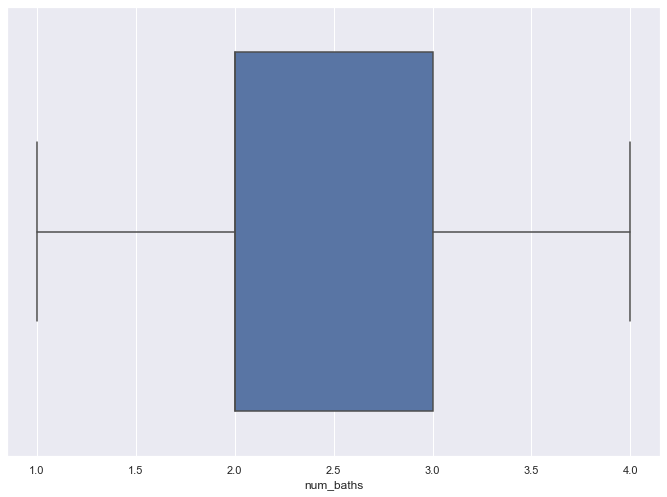

In [92]:
test.loc[test['num_baths'] > 4, 'num_baths'] = 4
sns.boxplot(train['num_baths'])

### num_beds
##### Number of bedrooms

In [93]:
avgbed = train['num_beds'].median()
train['num_beds'] = train['num_beds'].fillna(avgbath)

avgbed = test['num_beds'].median()
test['num_beds'] = test['num_beds'].fillna(avgbath)

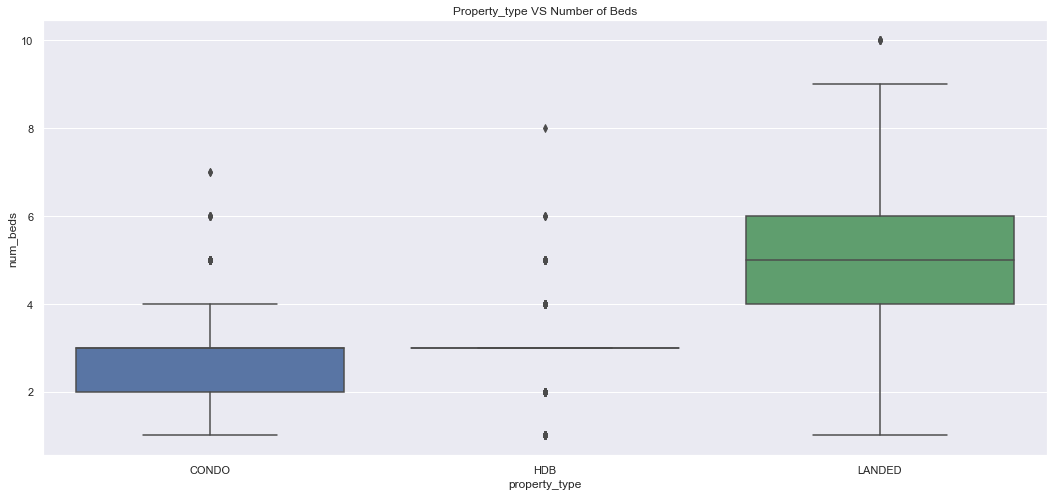

In [94]:
fig, axes = plt.subplots(figsize=(18,8))
sns.boxplot(x ='property_type', y= 'num_beds', data=test)
axes.set_title('Property_type VS Number of Beds')
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_beds'>

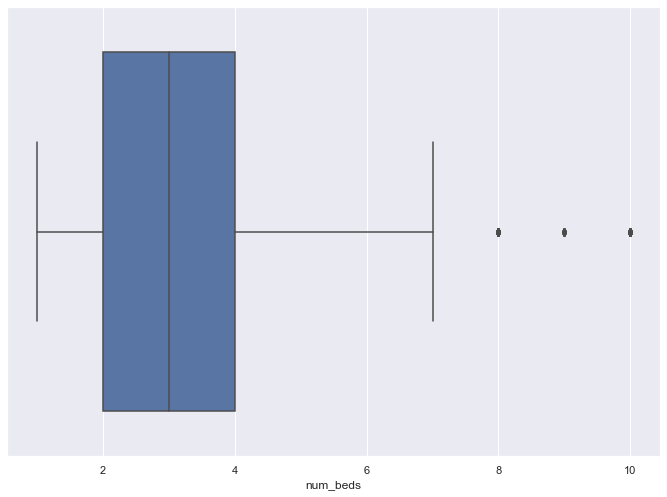

In [95]:
sns.boxplot(train['num_beds'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_beds'>

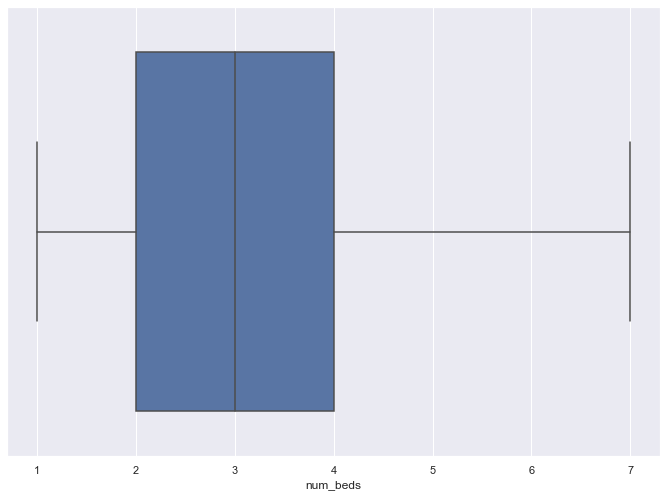

In [96]:
train.loc[train['num_beds'] > 7, 'num_beds'] = 7
sns.boxplot(train['num_beds'])

### available_unit_types
##### List of variety of units available in the property complex (e.g., studio).

In [97]:
numavaunittypes = train.available_unit_types.str.count(',') + 1
train['available_unit_types'] = numavaunittypes

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='available_unit_types'>

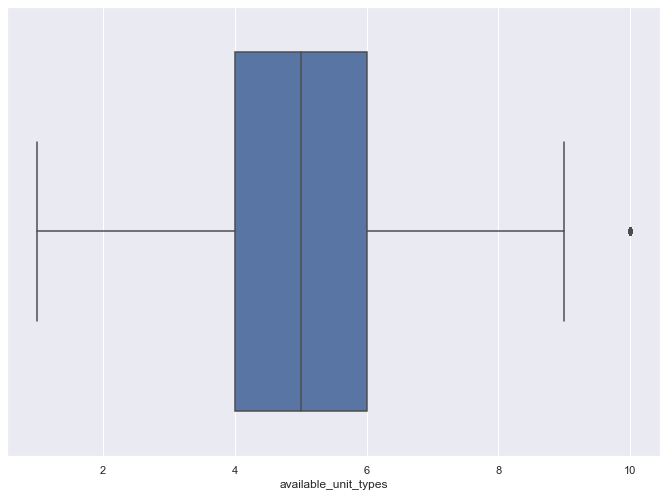

In [98]:
sns.boxplot(train['available_unit_types'])

In [99]:
train.loc[train['available_unit_types'] > 9, 'available_unit_types'] = 9

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='available_unit_types'>

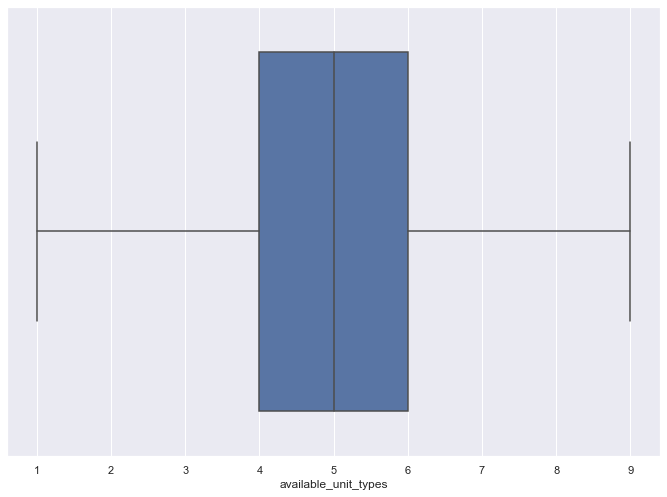

In [100]:
sns.boxplot(train['available_unit_types'])

In [101]:
avg_ava_units = train['available_unit_types'].median()
train['available_unit_types'] = train['available_unit_types'].fillna(avg_ava_units)

In [102]:
numavaunittypes = test.available_unit_types.str.count(',') +1
test['available_unit_types'] = numavaunittypes

In [103]:
avg_ava_units = test['available_unit_types'].median()
test['available_unit_types'] = test['available_unit_types'].fillna(avg_ava_units)

In [104]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,size_sqft,furnishing,available_unit_types,total_num_units,lat,...,subzone,planning_area,price,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size
0,HDB,99-year leasehold,1988.0,3.0,2.0,1115,unfurnished,5.0,116.0,1.414399,...,yishun,yishun,514500.0,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329
1,HDB,99-year leasehold,1992.0,4.0,2.0,1575,unfurnished,6.0,296.0,1.372597,...,serangoon,serangoon,995400.0,2.400374,6.871207,8.310177,6.710202,6.710202,18660,3.5000
2,CONDO,freehold,2022.0,4.0,4.0,3070,partial,5.0,56.0,1.298773,...,marine parade,marine parade,8485000.0,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068
3,CONDO,freehold,2023.0,3.0,2.0,958,partial,5.0,638.0,1.312364,...,bukit timah,bukit timah,2626000.0,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110
4,CONDO,99-year leasehold,2026.0,2.0,1.0,732,unfurnished,6.0,351.0,1.273959,...,downtown core,downtown core,1764000.0,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092


In [105]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
size_sqft                      int64
furnishing                    object
available_unit_types         float64
total_num_units              float64
lat                          float64
lng                          float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
dtype: object

### Price 

Removing outliers where price is 0

In [106]:
train = train[train['price'] != 0]

In [107]:
train['log_price'] = np.log(train['price'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

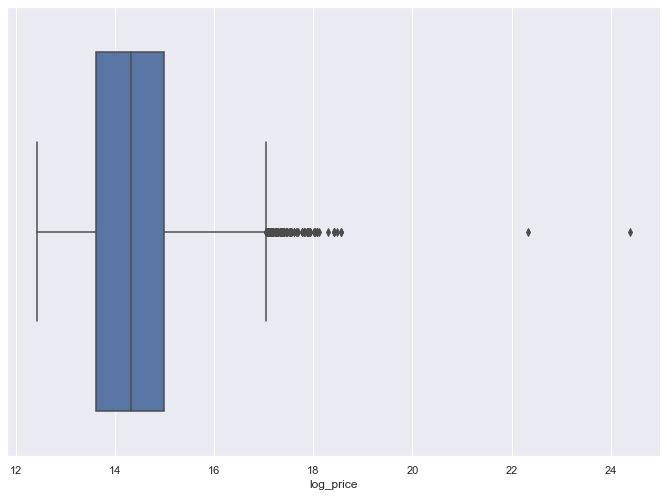

In [108]:
sns.boxplot(train['log_price'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

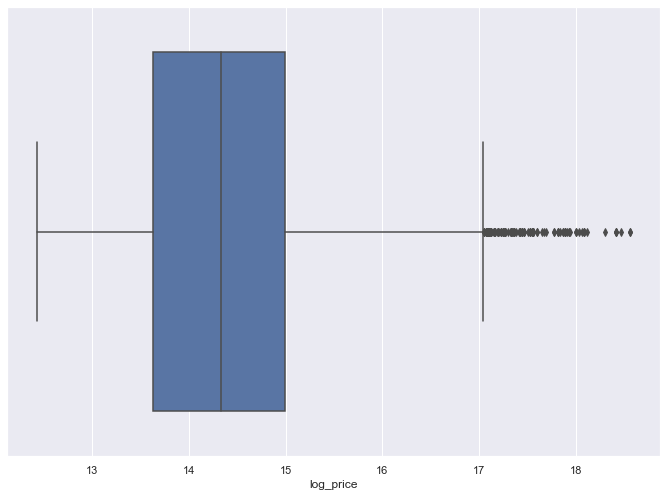

In [109]:
train = train[train['log_price']<20]
sns.boxplot(train['log_price'])

<AxesSubplot:xlabel='log_price', ylabel='property_type'>

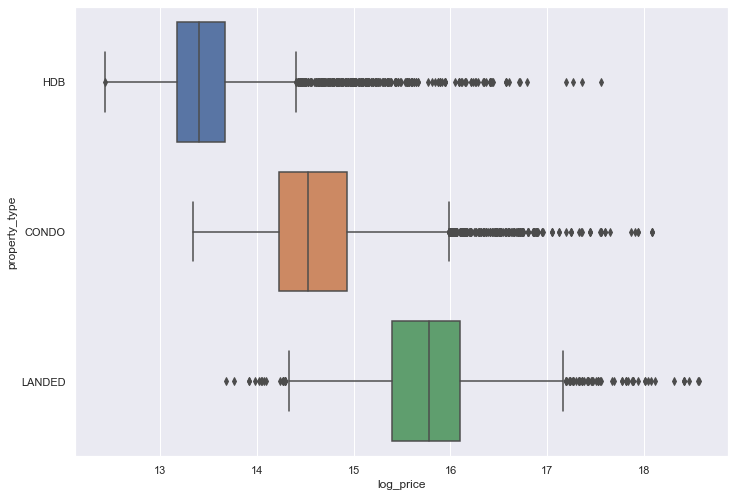

In [110]:
sns.boxplot(x=train['log_price'], y =train['property_type'])

<AxesSubplot:xlabel='log_price', ylabel='property_type'>

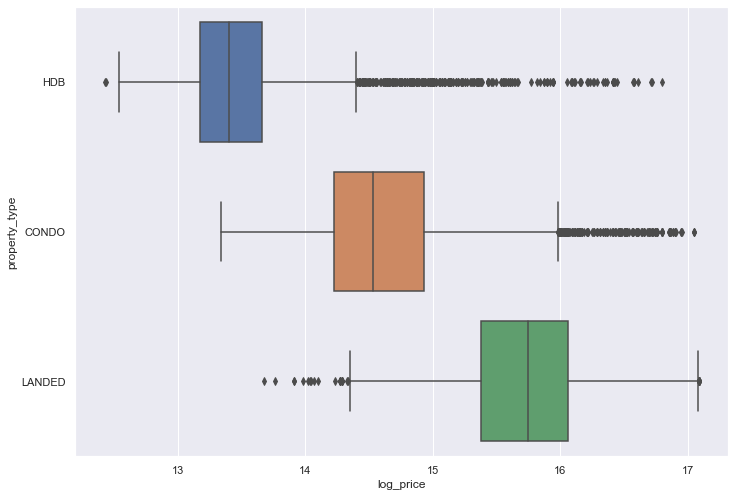

In [111]:
train = train[train['log_price'] < 17.1]
sns.boxplot(x=train['log_price'], y =train['property_type'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_price'>

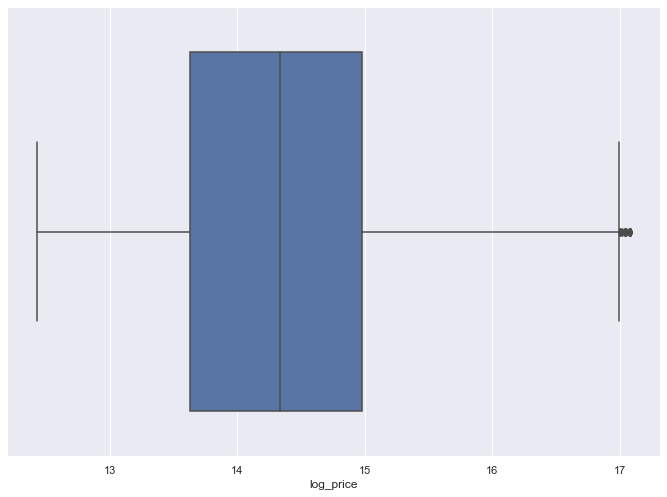

In [112]:
sns.boxplot(train['log_price'])

In [113]:
train = train[train['log_price'] <= 17]

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

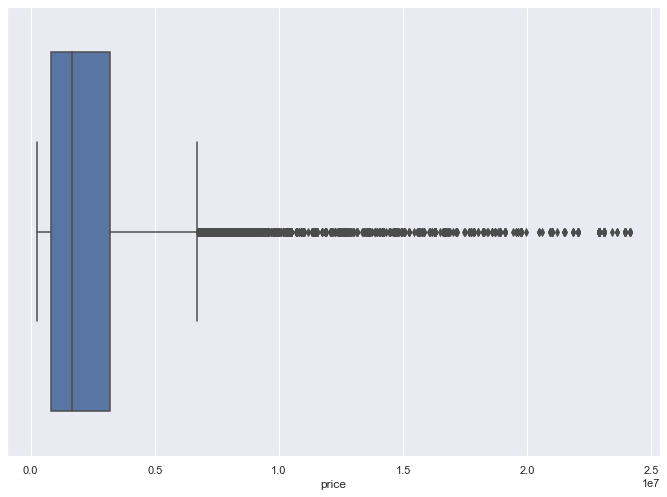

In [114]:
sns.boxplot(train['price'])

In [115]:
train.count()

property_type                19994
tenure                       19994
built_year                   19994
num_beds                     19994
num_baths                    19994
size_sqft                    19994
furnishing                   19994
available_unit_types         19994
total_num_units              19994
lat                          19994
lng                          19994
subzone                      19994
planning_area                19994
price                        19994
cc_distance                  19994
mrt_distance                 19994
primary_school_distance      19994
secondary_school_distance    19994
shop_distance                19994
population                   19994
area_size                    19994
log_price                    19994
dtype: int64

### size_sqft
##### Floor area in square feet

<AxesSubplot:xlabel='size_sqft'>

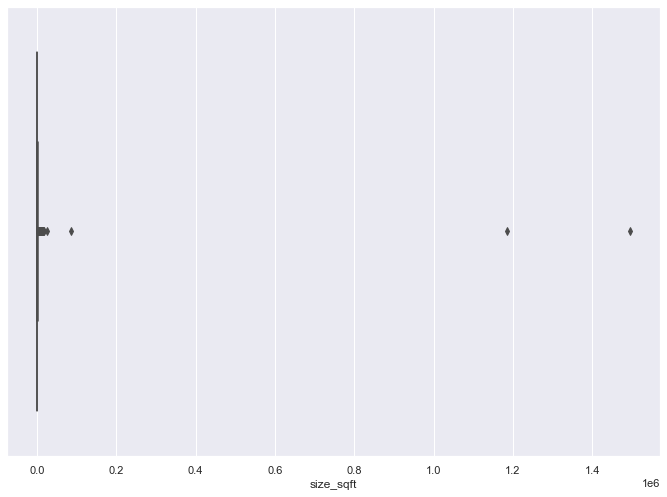

In [116]:
sns.boxplot(x = train['size_sqft'])

In [117]:
train['log_size_sqft'] = np.log(train['size_sqft'])
test['log_size_sqft'] = np.log(test['size_sqft'])

In [118]:
train = train.drop(columns='size_sqft')
test = test.drop(columns='size_sqft')

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_size_sqft'>

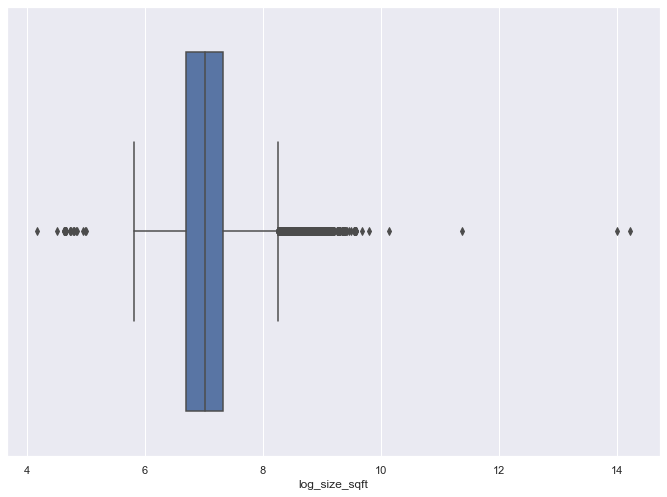

In [119]:
sns.boxplot(train['log_size_sqft'])

<AxesSubplot:xlabel='log_size_sqft', ylabel='property_type'>

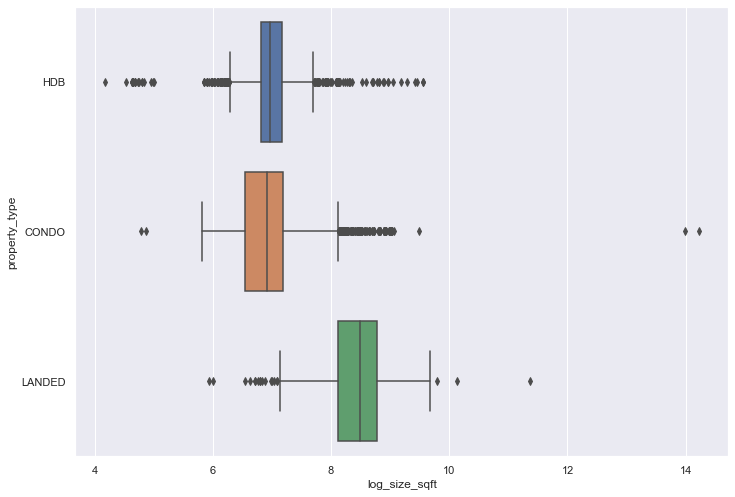

In [120]:
sns.boxplot(x = train['log_size_sqft'], y = train['property_type'])

In [121]:
train = train[train['log_size_sqft'] <9.7]

<AxesSubplot:xlabel='log_size_sqft', ylabel='property_type'>

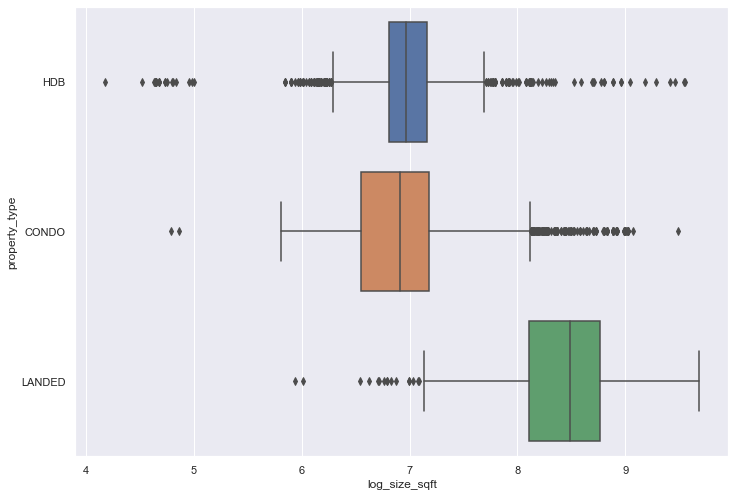

In [122]:
sns.boxplot(x = train['log_size_sqft'], y = train['property_type'])

<AxesSubplot:xlabel='log_size_sqft', ylabel='property_type'>

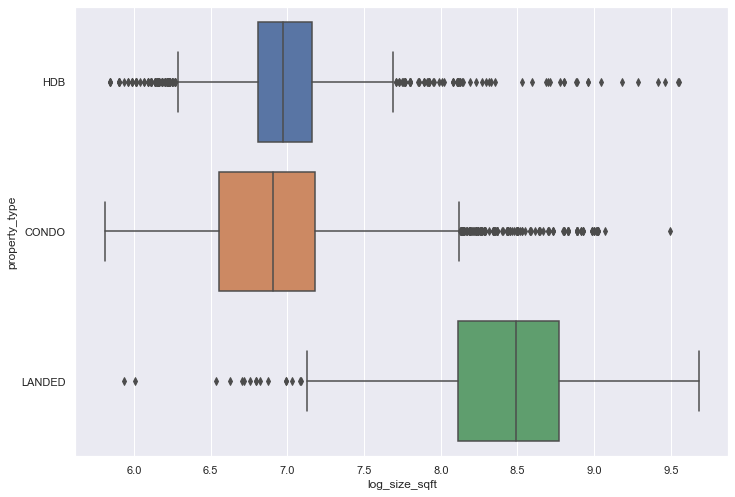

In [123]:
train = train[train['log_size_sqft'] > 5.5]
sns.boxplot(x = train['log_size_sqft'], y = train['property_type'])

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='log_size_sqft'>

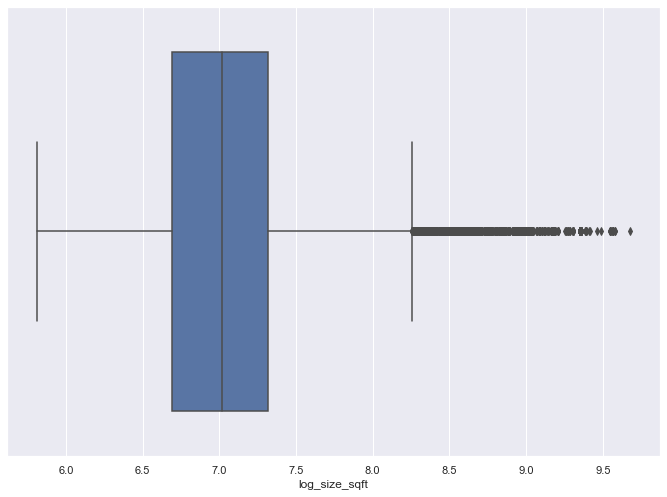

In [124]:
sns.boxplot(train['log_size_sqft'])

### subzone and planning_area
##### Subzone of block containing the flat in meter (e.g., "blangah rise", "marymount") 
##### Planning area of block containing the flat (e.g., "woodlands", "bukit merah") 

In [125]:
# adding regions
central = ['bishan', 'bukit merah', 'bukit timah', 'downtown core', 'geylang', 'kallang', 'marina east', 'marina south', 'marine parade', 'museum', 'newton',
           'novena', 'orchard', 'outram', 'queenstown', 'river valley', 'rochor', 'singapore river', 'southern islands', 'straits view', 'tanglin', 'toa payoh', 'geyland']

east = [ 'bedok', 'changi', 'changi bay', 'pasir ris', 'paya lebar', 'tampines']

north = ['central water catchment', 'lim chu kang', 'mandai', 'sembawang', 'simpang', 'sungei kadut', 'woodlands', 'yishun']

north_east = ['ang mo kio', 'hougang', 'north-eastern islands', 'punggol', 'seletar', 'sengkang', 'serangoon']

west = ['boon lay', 'bukit batok', 'bukit panjang', 'choa chu kang', 'clementi', 'jurong east', 'jurong west', 'pioneer', 'tengah', 'tuas', 'western islands', 'western water catchment']

In [126]:
train['region'] = train['subzone'].copy()

In [127]:
train['region'] = train['region'].replace(
    central,
    'central'
)

train['region'] = train['region'].replace(
    east,
    'east'
)

train['region'] = train['region'].replace(
    north,
    'north'
)

train['region'] = train['region'].replace(
    north_east,
    'north_east'
)

train['region'] = train['region'].replace(
    west,
    'west'
)

In [128]:
train.head()

,property_type,tenure,built_year,num_beds,num_baths,furnishing,available_unit_types,total_num_units,lat,lng,...,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,log_price,log_size_sqft,region
0,HDB,99-year leasehold,1988.0,3.0,2.0,unfurnished,5.0,116.0,1.414399,103.837196,...,8.027727,1.689357,5.178683,2.538065,2.538065,10250,1.4329,13.150951,7.016610,north
1,HDB,99-year leasehold,1992.0,4.0,2.0,unfurnished,6.0,296.0,1.372597,103.875625,...,2.400374,6.871207,8.310177,6.710202,6.710202,18660,3.5000,13.810900,7.362011,north_east
2,CONDO,freehold,2022.0,4.0,4.0,partial,5.0,56.0,1.298773,103.895798,...,6.389766,13.983476,9.485153,15.197137,15.197137,890,2.2068,15.953810,8.029433,central
3,CONDO,freehold,2023.0,3.0,2.0,partial,5.0,638.0,1.312364,103.803271,...,8.802339,13.479646,3.290085,12.950660,12.950660,28000,1.5110,14.780972,6.864848,central
4,CONDO,99-year leasehold,2026.0,2.0,1.0,unfurnished,6.0,351.0,1.273959,103.843635,...,9.160635,15.981982,13.818954,17.977600,17.977600,4370,2.2092,14.383095,6.595781,central


In [129]:
train['region']

0             north
1        north_east
2           central
3           central
4           central
            ...    
20249    north_east
20250       central
20251       central
20252         north
20253       central
Name: region, Length: 19967, dtype: object

<AxesSubplot:xlabel='region', ylabel='count'>

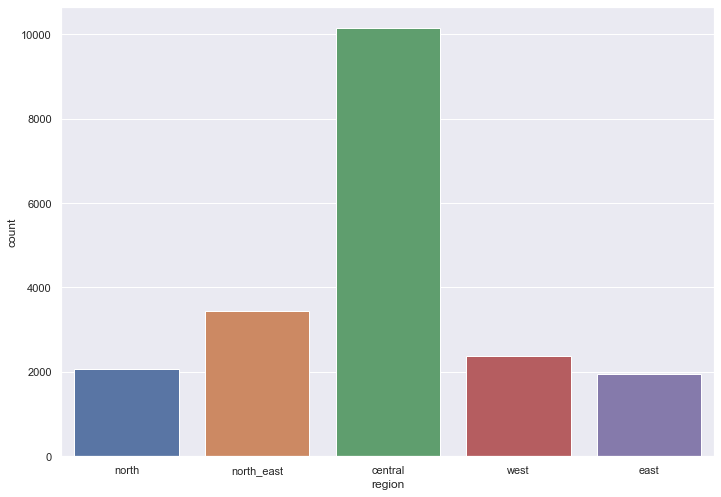

In [130]:
sns.countplot(x='region', data=train)

In [131]:
test['region'] = test['subzone'].copy()
test['region'].unique()

array(['serangoon', 'pasir ris', 'museum', 'choa chu kang', 'toa payoh',
       'geylang', 'clementi', 'yishun', 'hougang', 'sengkang',
       'bukit batok', 'bukit panjang', 'woodlands', 'ang mo kio',
       'downtown core', 'queenstown', 'kallang', 'bukit timah', 'bedok',
       'river valley', 'novena', 'seletar', 'bishan', 'outram', 'tanglin',
       'jurong west', 'marine parade', 'punggol', 'sembawang',
       'singapore river', 'bukit merah', 'southern islands', 'changi',
       'newton', 'tampines', 'orchard', 'jurong east', 'tengah', 'rochor',
       'central water catchment', 'geyland', 'lim chu kang', 'mandai',
       'boon lay'], dtype=object)

In [132]:
test['region'] = test['region'].replace(
    central,
    'central'
)

test['region'] = test['region'].replace(
    east,
    'east'
)

test['region'] = test['region'].replace(
    north,
    'north'
)

test['region'] = test['region'].replace(
    north_east,
    'north_east'
)

test['region'] = test['region'].replace(
    west,
    'west'
)

test['region'].unique()

array(['north_east', 'east', 'central', 'west', 'north'], dtype=object)

In [133]:
test.head()

,property_type,tenure,built_year,num_beds,num_baths,furnishing,available_unit_types,total_num_units,lat,lng,...,planning_area,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,log_size_sqft,region
0,CONDO,freehold,2022.0,1.0,1.0,unfurnished,6.0,250.0,1.344334,103.878690,...,serangoon,1.046868,0.960436,13.993735,1.853769,1.853769,8490,1.1801,6.137727,north_east
1,CONDO,99-year leasehold,2017.0,3.0,3.0,unfurnished,6.0,463.0,1.380281,103.943878,...,pasir ris,8.581574,9.346690,13.709624,8.403509,8.403509,14700,2.3307,6.940222,east
2,CONDO,99-year leasehold,2007.0,1.0,1.0,fully,4.0,646.0,1.294668,103.850074,...,museum,6.755363,6.710905,8.965840,6.503082,6.503082,24760,1.0619,6.345636,central
3,HDB,99-year leasehold,2017.0,3.0,2.0,unfurnished,5.0,900.0,1.373120,103.746094,...,choa chu kang,14.229296,14.293216,12.559347,13.963584,13.963584,36080,3.0232,7.103322,west
4,HDB,99-year leasehold,1973.0,3.0,2.0,unfurnished,4.0,298.0,1.341468,103.849047,...,toa payoh,2.802424,2.077951,6.903112,3.079569,3.079569,15940,0.6847,6.841615,central


### Types

In [134]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
furnishing                    object
available_unit_types         float64
total_num_units              float64
lat                          float64
lng                          float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
log_price                    float64
log_size_sqft                float64
region                        object
dtype: object

### Remove Redundant features

In [135]:
train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
furnishing                    object
available_unit_types         float64
total_num_units              float64
lat                          float64
lng                          float64
subzone                       object
planning_area                 object
price                        float64
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
log_price                    float64
log_size_sqft                float64
region                        object
dtype: object

In [136]:
test.count()

property_type                6966
tenure                       6966
built_year                   6966
num_beds                     6966
num_baths                    6966
furnishing                   6966
available_unit_types         6966
total_num_units              6966
lat                          6966
lng                          6966
subzone                      6966
planning_area                6966
cc_distance                  6966
mrt_distance                 6966
primary_school_distance      6966
secondary_school_distance    6966
shop_distance                6966
population                   6966
area_size                    6966
log_size_sqft                6966
region                       6966
dtype: int64

### Distance Correlation Analysis

In [137]:
distance_list = ['cc_distance', 'mrt_distance', 'primary_school_distance', 'secondary_school_distance', 'shop_distance']
print('spearman:')
for distance_type in distance_list:
    print(train[distance_type].corr(y_train, method='spearman'))
print('kendall:')
for distance_type in distance_list:
    print(train[distance_type].corr(y_train, method='kendall'))

spearman:


NameError: name 'y_train' is not defined

The distance ranked by correlation is like this:
1. distance to MRT station
2. distance to Commercial Centre
3. distance to Shopping mall
4. distance to Secondary school
5. distance to Primary school
Result shows that the influence of distance to Primary school is very little and can almost be ignored. On the contrary, distance to MRT station affect the price obviously.

##### Prominent primary schools
- Add a new feature on [popular primary schools](https://www.moe.gov.sg/primary/p1-registration/distance) priority is given to people living < 2 km near these schools.
- Added [top 28 oversubscribed schools](https://www.salary.sg/2022/best-primary-schools-2022-by-popularity/)

In [ ]:
# Top 28 oversubscribed schools
pslist = """
Methodist Girls’ School (Primary) – 20/79 (2.55)
Catholic High School (Primary Section) – 20/43 (1.74)
Tao Nan School – 23/61 (1.74)
Pei Hwa Presbyterian Primary School – 20/37 (1.64)
Holy Innocents’ Primary School – 21/50 (1.64)
Nan Hua Primary School – 20/38 (1.61)
CHIJ St. Nicholas Girls’ School (Primary Section) – 20/46 (1.59)
Admiralty Primary School – 22/49 (1.52)
St. Hilda’s Primary School – 20/40 (1.49)
Ai Tong School – 20/48 (1.45)
Anglo-Chinese School (Junior) – 27/57 (1.44)
Chongfu School – 25/51 (1.35)
St. Joseph’s Institution Junior – 38/84 (1.35)
Anglo-Chinese School (Primary) – 28/55 (1.34)
Singapore Chinese Girls’ Primary School – 20/34 (1.30)
Nanyang Primary School – 20/37 (1.30)
South View Primary School – 20/30 (1.29)
Pei Chun Public School – 20/27 (1.27)
Kong Hwa School – 32/65 (1.20)
Rosyth School – 20/24 (1.18)
Maris Stella High School (Primary Section) – 27/45 (1.18)
Nan Chiau Primary School – 41/79 (1.13)
Fairfield Methodist School (Primary) – 20/33 (1.13)
CHIJ Primary (Toa Payoh) – 27/40 (1.12)
Henry Park Primary School – 21/29 (1.10)
Kuo Chuan Presbyterian Primary School – 31/54 (1.10)
Red Swastika School – 20/26 (1.08)
Rulang Primary School – 20/34 (1.07)
"""

In [ ]:
psl = []
for school in pslist.split('\n'):
    if school != '':
        num_idx = [elem for elem in school if elem.isnumeric()] # Find index of numbers
        num_idx = school.index(num_idx[0])-3 # The first number is always after the '-'
        school = school[:num_idx]
        # If there is '(Primary)' inside the term
        if '(Primary' in school:
            school = school[:school.index('(Primary')-1]
        # # Get the school main name
        # school = school.split(' ')[:2]
        # Replace special character ’ with '
        school = school.replace("’", "'" )
        # psl.append(' '.join(school))
        psl.append(school)
print(psl)

["Methodist Girls' School", 'Catholic High School', 'Tao Nan School', 'Pei Hwa Presbyterian Primary School', "Holy Innocents' Primary School", 'Nan Hua Primary School', "CHIJ St. Nicholas Girls' School", 'Admiralty Primary School', "St. Hilda's Primary School", 'Ai Tong School', 'Anglo-Chinese School (Junior)', 'Chongfu School', "St. Joseph's Institution Junior", 'Anglo-Chinese School', "Singapore Chinese Girls' Primary School", 'Nanyang Primary School', 'South View Primary School', 'Pei Chun Public School', 'Kong Hwa School', 'Rosyth School', 'Maris Stella High School', 'Nan Chiau Primary School', 'Fairfield Methodist School', 'CHIJ Primary (Toa Payoh)', 'Henry Park Primary School', 'Kuo Chuan Presbyterian Primary School', 'Red Swastika School', 'Rulang Primary School']


In [ ]:
target_ps = set()
for name in primaryschooldistance.name.values:
    for target in psl:
        if target in name:
            target_ps.add(name)
target_ps

{'Admiralty Primary School',
 'Ai Tong School',
 'Anglo-Chinese School (Primary)',
 'CHIJ Primary (Toa Payoh)',
 "CHIJ St. Nicholas Girls' School",
 'Catholic High School (Primary)',
 'Chongfu School',
 'Fairfield Methodist School (Primary)',
 'Henry Park Primary School',
 "Holy Innocents' Primary School",
 'Kong Hwa School',
 'Kuo Chuan Presbyterian Primary School',
 'Maris Stella High School',
 "Methodist Girls' School (Primary)",
 'Nan Chiau Primary School',
 'Nanyang Primary School',
 "Paya Lebar Methodist Girls' School (Primary)",
 'Pei Chun Public School',
 'Pei Hwa Presbyterian Primary School',
 'Red Swastika School',
 'Rosyth School',
 'Rulang Primary School',
 'South View Primary School',
 "St. Hilda's Primary School",
 "St. Joseph's Institution Junior",
 'Tao Nan School'}

Some schools have duplicate (Anglo-Chinese and Anglo-Chinese (Junior)) but is actually the same school located in the same location 

In [ ]:
target_ps = primaryschooldistance[primaryschooldistance.name.isin(list(target_ps))]
target_ps.sort_values(by=['subzone'])

,name,lat,lng,subzone,planning_area
80,Kong Hwa School,1.311261,103.888199,aljunied,serangoon
112,Pei Hwa Presbyterian Primary School,1.338099,103.776219,anak bukit,serangoon
96,Nan Chiau Primary School,1.392027,103.891042,anchorvale,serangoon
127,Red Swastika School,1.333420,103.934220,bedok north,serangoon
88,Maris Stella High School,1.341431,103.877655,bidadari,serangoon
82,Kuo Chuan Presbyterian Primary School,1.349224,103.855026,bishan east,serangoon
2,Ai Tong School,1.375016,103.857415,cheng san,serangoon
65,Holy Innocents' Primary School,1.375016,103.857415,cheng san,serangoon
49,Fairfield Methodist School (Primary),1.300820,103.785649,dover,serangoon
97,Nanyang Primary School,1.320832,103.808217,farrer court,serangoon


In [ ]:
target_ps.lat.values

array([1.4429414 , 1.3750164 , 1.31875235, 1.29721925, 1.3331269 ,
       1.37422574, 1.4387276 , 1.30081995, 1.3750164 , 1.3170569 ,
       1.31126062, 1.3492238 , 1.341431  , 1.34993195, 1.39202675,
       1.32083185, 1.34993195, 1.33731177, 1.3380993 , 1.33341967,
       1.37319819, 1.34660905, 1.38236605, 1.34987736, 1.31764038,
       1.30506679])

In [ ]:
target_loc = {'lat':target_ps.lat.values, 'lng':target_ps.lng.values}
target_loc

{'lat': array([1.4429414 , 1.3750164 , 1.31875235, 1.29721925, 1.3331269 ,
        1.37422574, 1.4387276 , 1.30081995, 1.3750164 , 1.3170569 ,
        1.31126062, 1.3492238 , 1.341431  , 1.34993195, 1.39202675,
        1.32083185, 1.34993195, 1.33731177, 1.3380993 , 1.33341967,
        1.37319819, 1.34660905, 1.38236605, 1.34987736, 1.31764038,
        1.30506679]),
 'lng': array([103.80034507, 103.85741485, 103.83507692, 103.85183918,
        103.842403  , 103.8341542 , 103.83929013, 103.78564896,
        103.85741485, 103.78421633, 103.88819876, 103.85502581,
        103.87765467, 103.88492376, 103.89104245, 103.80821659,
        103.88492376, 103.85582516, 103.77621882, 103.93422016,
        103.87469674, 103.718737  , 103.75599912, 103.93609377,
        103.84554447, 103.91142327])}

In [ ]:
len(target_loc)

2

In [ ]:
expected_result = pd.merge(train, target_ps, on = 'subzone')


def near_ps(t_lat, t_lng):
    # target_loc of [lat, lng]
    min_dist = np.inf
    for i in range(len(target_loc['lat'])):
        temp_d = haversine_np(t_lng, t_lat, target_loc['lng'][i], target_loc['lat'][i])
        if min_dist > temp_d:
            min_dist = temp_d
    return 1 if min_dist <= 2 else 0

train['near_top_ps'] = train.apply(lambda row : near_ps(row['lat'], row['lng']), axis = 1)

In [ ]:
train['near_top_ps'].value_counts()

1    14641
0     5326
Name: near_top_ps, dtype: int64

### On Price

/var/folders/hw/mscg25jd51j3j1pnmt3tnwg00000gn/T/ipykernel_38858/4170676154.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['price'],kde=False)
/var/folders/hw/mscg25jd51j3j1pnmt3tnwg00000gn/T/ipykernel_38858/4170676154.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(train['

Text(0.5, 0, 'Log (sale price)')

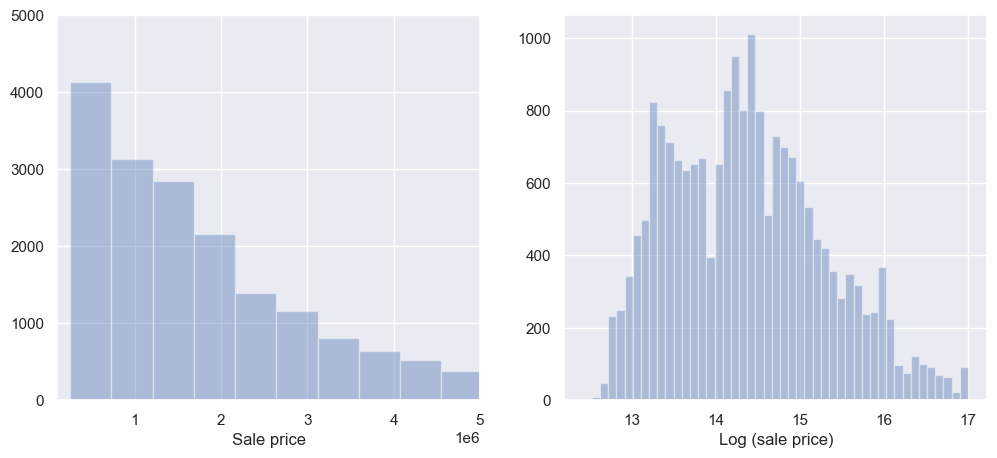

In [ ]:
# Set up the matplotlib figure
plt.figure(figsize=(12,5))
#f, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.subplot(121)
sns.distplot(train['price'],kde=False)
plt.xlabel('Sale price')
plt.axis([100000,5000000,0,5000])
plt.subplot(122)
sns.distplot(np.log(train['price']),kde=False)
plt.xlabel('Log (sale price)')
# plt.axis([10,14,0,180])

### Overall correlation

<AxesSubplot: >

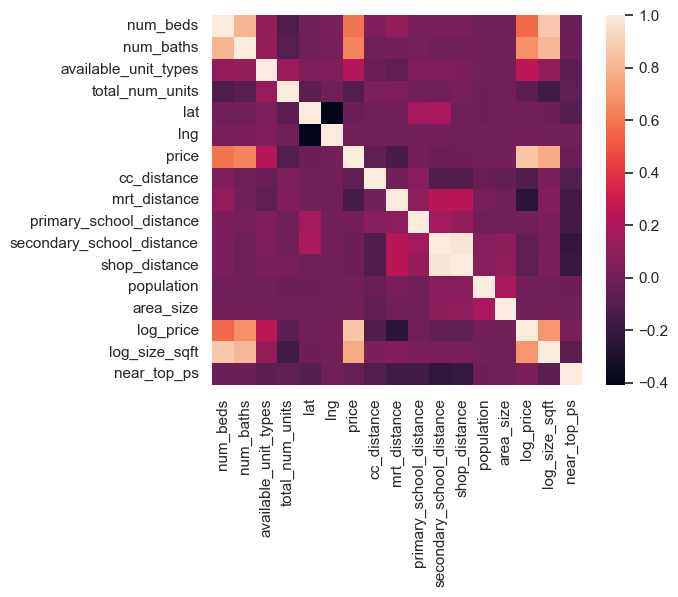

In [ ]:
corr = train.select_dtypes(include = ['float64', 'int64']).iloc[:,1:].corr()
#fig = plt.figure()
sns.set(font_scale=1)  
sns.heatmap(corr, vmax=1, square=True)

In [ ]:
corr_list = corr['log_price'].sort_values(axis=0,ascending=False).iloc[1:] # removes price
corr_list = corr_list[1:]

In [ ]:
corr_list

log_size_sqft                0.697429
num_baths                    0.676896
num_beds                     0.557271
available_unit_types         0.250777
near_top_ps                  0.033402
lng                          0.012338
area_size                    0.006972
population                   0.005391
lat                          0.002472
primary_school_distance     -0.003889
secondary_school_distance   -0.055665
shop_distance               -0.062233
total_num_units             -0.073563
cc_distance                 -0.111482
mrt_distance                -0.244142
Name: log_price, dtype: float64

We want to get the biggest absolute value, which shows positively or negatively correlation, and try not to get variables that are close to 0.

In [ ]:
corr_list = corr_list.abs().sort_values(axis=0,ascending=False).iloc[1:]

In [ ]:
corr_list

num_baths                    0.676896
num_beds                     0.557271
available_unit_types         0.250777
mrt_distance                 0.244142
cc_distance                  0.111482
total_num_units              0.073563
shop_distance                0.062233
secondary_school_distance    0.055665
near_top_ps                  0.033402
lng                          0.012338
area_size                    0.006972
population                   0.005391
primary_school_distance      0.003889
lat                          0.002472
Name: log_price, dtype: float64

Chart the price increase with each of the features, blue line shows the log_price, which displays *linearity* for some features, able to see linear patterns.

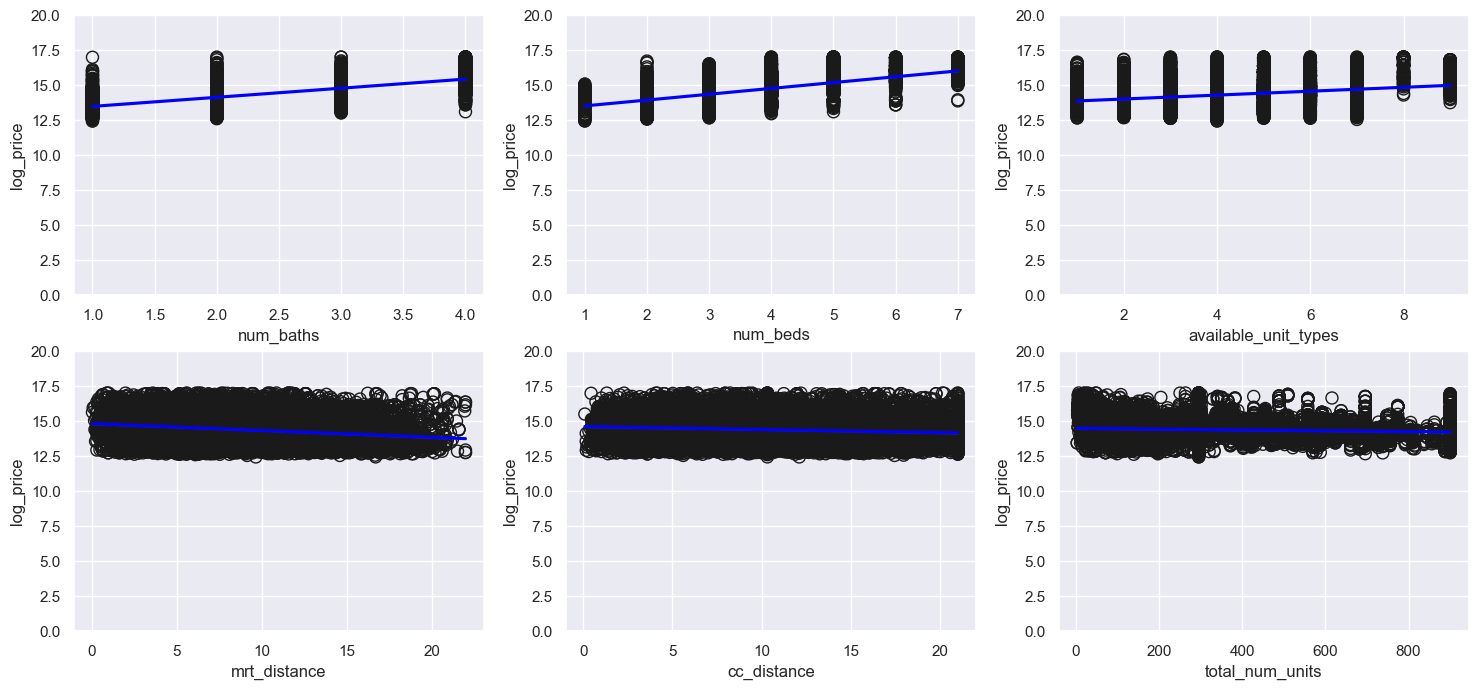

In [ ]:
plt.figure(figsize=(18,8))
for i in range(6):
    ii = '23'+str(i+1)
    plt.subplot(int(ii))
    feature = corr_list.index.values[i]
    plt.scatter(train[feature], train['log_price'], facecolors='none',edgecolors='k',s = 75)
    sns.regplot(x = feature, y = 'log_price', data = train,scatter=False, color = 'Blue')
    ax=plt.gca() 
    ax.set_ylim([0,20])

See the price distribution of each subzone in Singapore, sort by median to see the price distribution, color coded by region (NSEWC). Can see that a few areas are consistently high (newton, orchard, river valley), most are central areas as seen by the hue color. A few are outliers (mandai which is a land). 

In [ ]:
ps_df['region'].value_counts()

central       10145
north_east     3448
west           2368
north          2057
east           1949
Name: region, dtype: int64

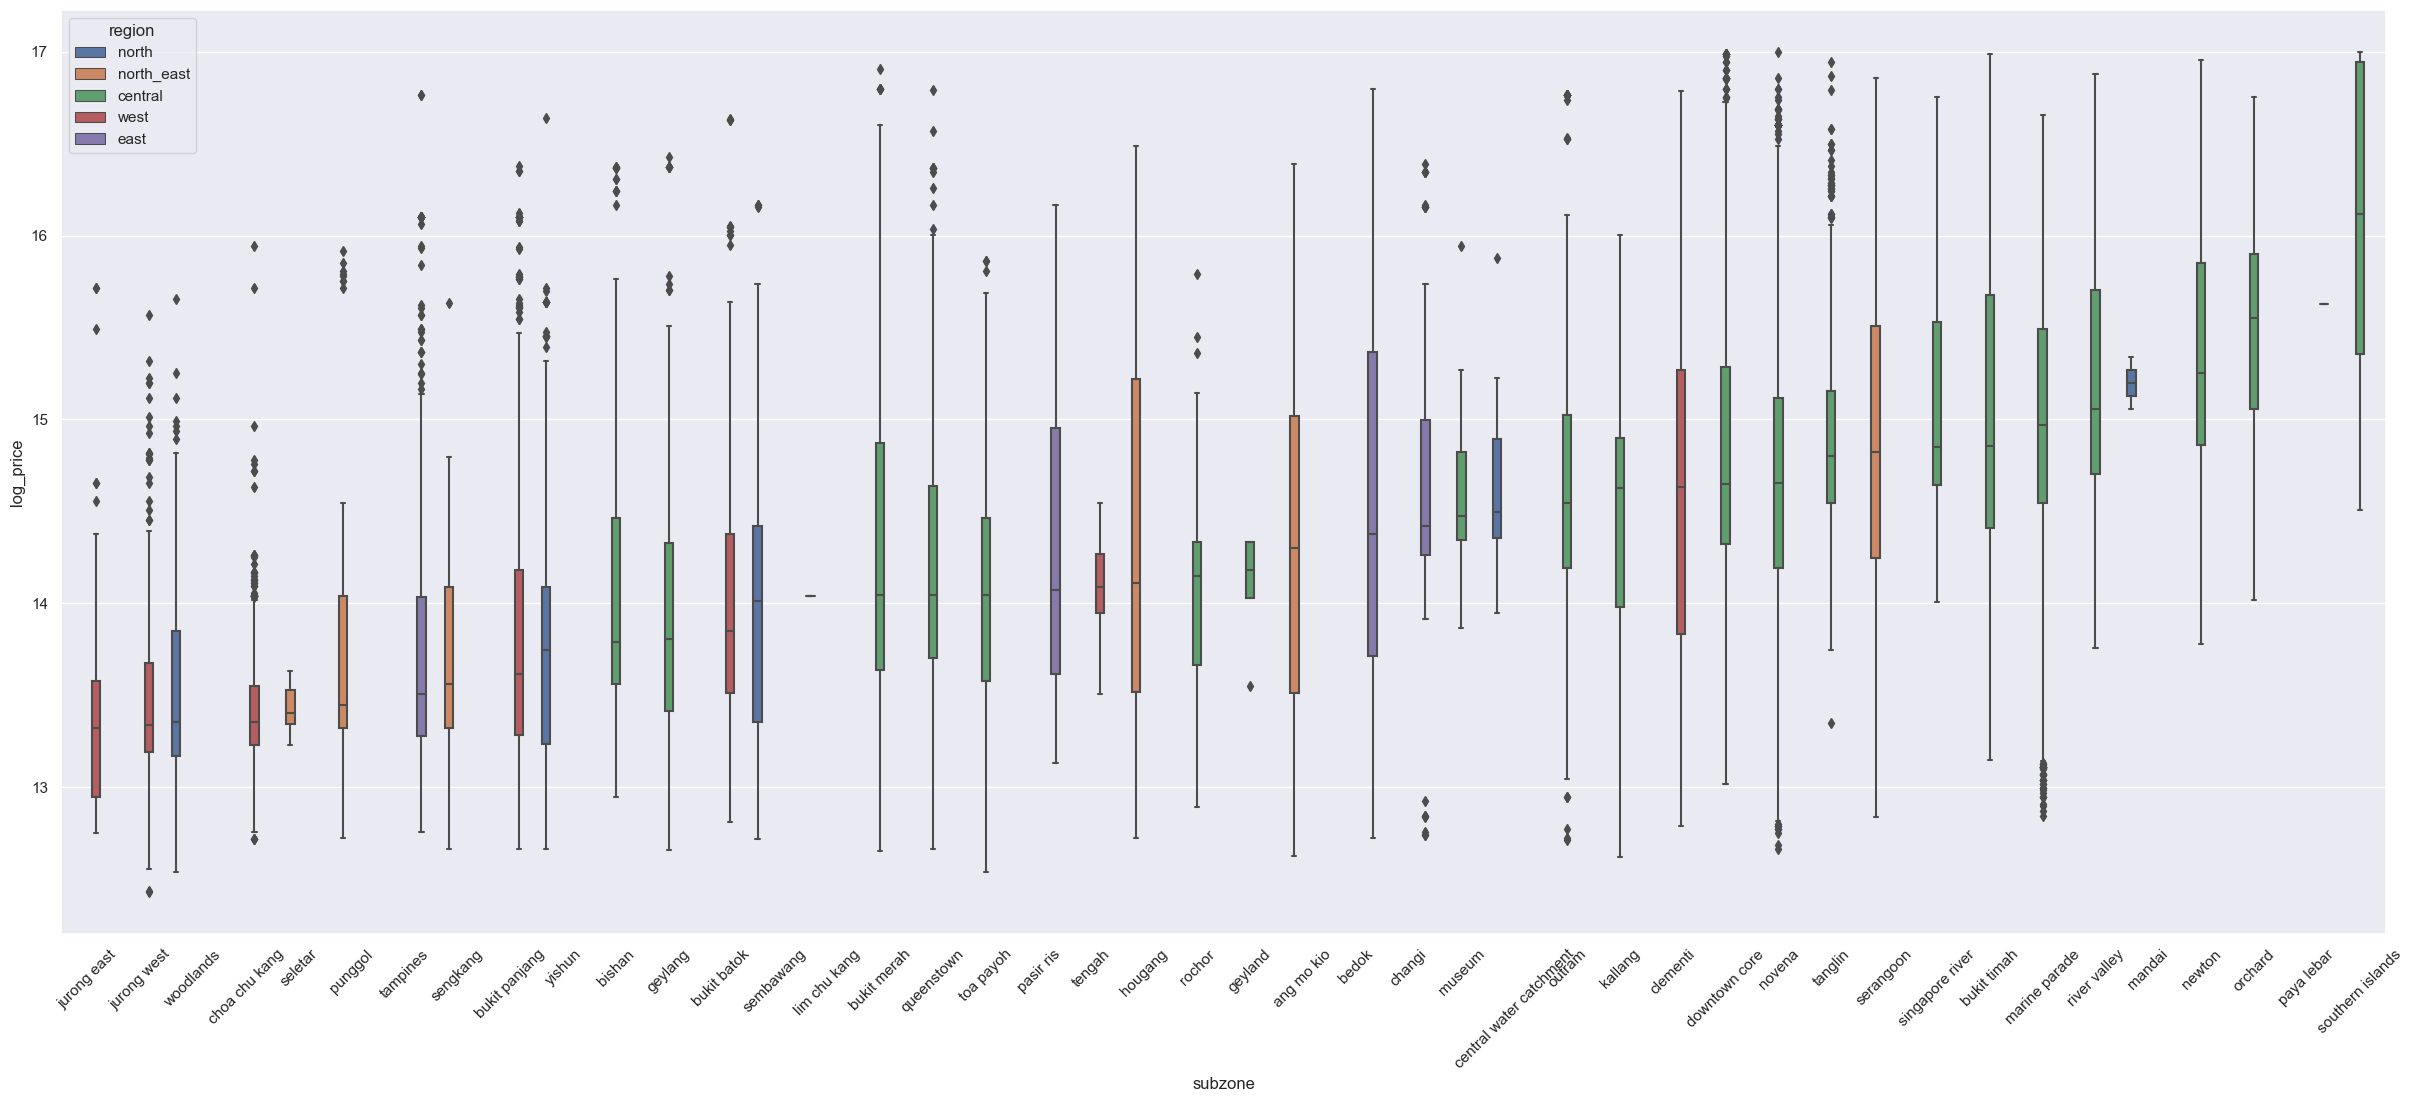

In [ ]:
ps_df = train.__deepcopy__()

plt.figure(figsize = (30, 12))
grouped = ps_df.groupby(["subzone"])
order = grouped.median()["log_price"].sort_values().index
sns.boxplot(x="subzone", y="log_price", hue="region", data=ps_df, order=order)#, palette=ps_df.region.unique())
xt = plt.xticks(rotation=45)

# Mining & Data Processing - Housing Apartment Price Prediction <a class="anchor" id="2"></a>
Involves a few steps to clean the noisy data and then prepare it for modeling.
1. Data Processing
- Feature Selection - Keep only Relevant data
- Outliers - Detect & Remove Outliers
- Cleaning - Fill up Null and Missing Data

2. Prepare pipeline and set up categorical and numerical columns

In [ ]:
train['property_type'].unique()

array(['HDB', 'CONDO', 'LANDED'], dtype=object)

#### Removal of LANDED property type

##### Landed properties are properties that are attached directly to the land that the buyer purchase. These properties may have differing tenures and rules that govern them from the non-landed counterparts in the private sector and in the public sector(HDB). Thus, they are removed as their prices could skew the data from normality.


In [ ]:
df_train = train[train["property_type"] != 'LANDED']
df_train = test[test["property_type"] != 'LANDED']

In [ ]:
df_train['property_type'].unique()

array(['CONDO', 'HDB'], dtype=object)

## Data Processing

### Feature Selection
Not all features are important, some features shows not significant correlation values and does not intuitively explain the correlation
- Remove all planning area related values (area_size, population)
- Remove school distance measure, most of the times schools only matters if the school itself is a prominent ranking school

In [ ]:
df_train.dtypes

property_type                 object
tenure                        object
built_year                   float64
num_beds                     float64
num_baths                    float64
furnishing                    object
available_unit_types         float64
total_num_units              float64
lat                          float64
lng                          float64
subzone                       object
planning_area                 object
cc_distance                  float64
mrt_distance                 float64
primary_school_distance      float64
secondary_school_distance    float64
shop_distance                float64
population                     int64
area_size                    float64
log_size_sqft                float64
region                        object
dtype: object

In [ ]:
df_train.head()

,property_type,tenure,built_year,num_beds,num_baths,furnishing,available_unit_types,total_num_units,lat,lng,...,planning_area,cc_distance,mrt_distance,primary_school_distance,secondary_school_distance,shop_distance,population,area_size,log_size_sqft,region
0,CONDO,freehold,2022.0,1.0,1.0,unfurnished,6.0,250.0,1.344334,103.878690,...,serangoon,1.046868,0.960436,13.993735,1.853769,1.853769,8490,1.1801,6.137727,north_east
1,CONDO,99-year leasehold,2017.0,3.0,3.0,unfurnished,6.0,463.0,1.380281,103.943878,...,pasir ris,8.581574,9.346690,13.709624,8.403509,8.403509,14700,2.3307,6.940222,east
2,CONDO,99-year leasehold,2007.0,1.0,1.0,fully,4.0,646.0,1.294668,103.850074,...,museum,6.755363,6.710905,8.965840,6.503082,6.503082,24760,1.0619,6.345636,central
3,HDB,99-year leasehold,2017.0,3.0,2.0,unfurnished,5.0,900.0,1.373120,103.746094,...,choa chu kang,14.229296,14.293216,12.559347,13.963584,13.963584,36080,3.0232,7.103322,west
4,HDB,99-year leasehold,1973.0,3.0,2.0,unfurnished,4.0,298.0,1.341468,103.849047,...,toa payoh,2.802424,2.077951,6.903112,3.079569,3.079569,15940,0.6847,6.841615,central


For Numerical Columns

In [ ]:
# Location-related features. Drop planning area related data, it is too broad to have a big impact
train = train.drop(columns=['lat','lng','subzone','planning_area', 'area_size'])
test = test.drop(columns=['lat','lng','subzone','planning_area', 'area_size'])

# Distance-related features, use only important ones
train = train.drop(columns=['primary_school_distance'])
test = test.drop(columns=['primary_school_distance'])

# Final numerical columns
x_train = train.drop(columns=['log_price'])
y_train = x_train.pop('price')

For categorical columns

In [ ]:
[x_train.dtypes=='O']

[property_type                 True
 tenure                        True
 built_year                   False
 num_beds                     False
 num_baths                    False
 furnishing                    True
 available_unit_types         False
 total_num_units              False
 cc_distance                  False
 mrt_distance                 False
 secondary_school_distance    False
 shop_distance                False
 population                   False
 log_size_sqft                False
 region                        True
 near_top_ps                  False
 dtype: bool]

In [ ]:
x_train.furnishing.value_counts()

unfurnished    16469
partial         2973
fully            525
Name: furnishing, dtype: int64

In [ ]:
# Custom OHE for furnishing
furnishing_list = ['unfurnished', 'partial', 'fully']
furnishing_processor = OrdinalEncoder(categories=[furnishing_list])

furnishing_ct = ColumnTransformer(
    [
        ('furnish_label', furnishing_processor, ['furnishing'])
    ], remainder='drop'
)

### Cleaning

## Pipeline

In [ ]:
# OHE for the other categorical variables
cat_columns = list(x_train.select_dtypes('object').columns)
cat_columns.remove('furnishing')
other_cat_processor = OneHotEncoder(handle_unknown="ignore")

final_cat_ct = ColumnTransformer(
    [
        ('OHE', other_cat_processor, cat_columns)
    ], remainder='drop'
)

In [ ]:
num_columns = list(x_train.select_dtypes(exclude=['object']).columns)

final_furnishing_preprocessor = Pipeline([
    ("furnishing_process", furnishing_ct),
    ("furnishing_robust", RobustScaler)
])

final_cat_preprocessor = Pipeline([
    ("othercat_process", final_cat_ct),
    ("othercat_robust", RobustScaler)
])

all_ct_pipeline = ColumnTransformer([
    ("furnishing", final_furnishing_preprocessor, ['furnishing']),
    ("cat", final_cat_ct, cat_columns),
    ("num", RobustScaler, num_columns), # Straight minmax all numerical
])


In [ ]:
x_train_scaled = all_ct_pipeline.fit_transform(x_train)

## Modelling

In [ ]:
# defining error functions for handy use. 
# https://www.kaggle.com/code/niteshx2/top-50-beginners-stacking-lgb-xgb/notebook

kfolds = RepeatedStratifiedKFold(n_splits=10, random_state=42)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(clf, x, y):
    rmse = np.sqrt(-cross_val_score(clf, x, y, scoring="neg_mean_squared_error", cv=kfolds, n_jobs=-1))
    return (rmse)

def get_PR_AUC(clf, x, y):
    avg_precision = cross_val_score(clf, x, y, scoring="neg_mean_squared_error", cv=kfolds, n_jobs=-1).mean()
    return (avg_precision)

### Level 0 Estimators Training

In [ ]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_alt, cv=kfolds))
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kfolds))
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))                                
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

In [ ]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state =42)                             

In [ ]:
lightgbm = lgb.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )


In [ ]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)


In [ ]:
# Using various prediction models that we just created 
score = cv_rmse(ridge, x_train_scaled, y_train)
score = cv_rmse(lasso, x_train_scaled, y_train)
print("LASSO: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("elastic net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("lightgbm: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("gbr: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("xgboost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

/Users/anthony/miniforge3/envs/spark/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/anthony/miniforge3/envs/spark/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/anthony/miniforge3/envs/spark/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/anthony/miniforge3/envs/spark/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/Users/anthony/miniforge3/envs/spark/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least popul

#### Stacking
- Implement use of http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

In [ ]:
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


In [ ]:
print('START Fit')

print('stack_gen')
stack_gen_model = stack_gen.fit(np.array(x_train_scaled), np.array(y_train))

print('elasticnet')
elastic_model_full_data = elasticnet.fit(x_train_scaled, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(x_train_scaled, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(x_train_scaled, y_train)

print('Svr')
svr_model_full_data = svr.fit(x_train_scaled, y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(x_train_scaled, y_train)

print('xgboost')
xgb_model_full_data = xgboost.fit(x_train_scaled, y_train)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(x_train_scaled, y_train)


#### Blending Models / "Ensambling"

In [ ]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))


In [ ]:
print('RMSLE score on train data:')
print(rmsle(y_train, blend_models_predict(x_train_scaled)))

In [ ]:
print('predict on test data:')
blend_models_predict(test)

# PREVIOUS WORK

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features = x_train.select_dtypes(include=numerics).columns

In [ ]:
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

In [ ]:
categorial = ['object']
categorical_features = x_train.select_dtypes(include=categorial).columns

In [ ]:
categorical_transformer = ce.OneHotEncoder(handle_unknown="ignore")

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_PR_AUC(clf, x, y):
    
    avg_precision = cross_val_score(clf, x, y, scoring="neg_mean_squared_error", cv=5, n_jobs=-1).mean()
    return (avg_precision)

### LightGBM

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", lgb.LGBMClassifier())]
)

param_grid = {'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler()], 
              'classifier__n_estimators': list(range(15,30,5)),
              'classifier__learning_rate': [0.01,0.05, 0.1],
              'classifier__max_depth': list(range(1,4,1))
}

In [ ]:
grid_LGB = GridSearchCV(clf, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2, n_jobs=-1) 


grid_LGB.fit(x_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=MinMaxScaler(); total time= 3.1min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=StandardScaler(); total time= 3.1min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=MinMaxScaler(); total time= 3.1min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=StandardScaler(); total time= 3.2min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=StandardScaler(); total time= 3.2min
[CV] END classifier__learning_rate=0.01, classifier__max_depth=1, classifier__n_estimators=15, preprocessor__num__scaler=MinMaxScaler(); total time= 3.2min
[CV] END classifier__learning_rate=0.01, classifier__max_d

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['built_year', 'num_beds', 'num_baths', 'available_unit_types',
       'total_num_units', 'cc_distance', 'mrt_distance',
       'primary_school_distance', 'secondary_school_distance', 'shop_distance',
       'population', 'area_siz...
                                                                         Index(['property_type', 'tenure', 'furnishing', 'region'], dtype='object'))])),
                                       ('classifier', LGBMClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.05, 0.1],
                         'classifier__max_depth': [1, 2, 3],
                         'classifier__n_estimators': [15, 20, 25],
                         'preprocessor__num__scaler': [StandardScaler(),
                                                       MinMaxScaler(),
                                                       RobustScaler(),
                                                       MaxAbsScaler()]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
grid_LGB.best_params_

{'classifier__learning_rate': 0.01,
 'classifier__max_depth': 2,
 'classifier__n_estimators': 25,
 'preprocessor__num__scaler': StandardScaler()}

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestRegressor(random_state=2022))]
)

param_grid = {'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler()], 
              'classifier__n_estimators': list(range(50,150,50)),
              'classifier__min_samples_split': list(range(2,6,2)),
              'classifier__min_samples_leaf': list(range(1,4,1)),
              'classifier__max_depth': list(range(1,4,1)),
              'classifier__criterion': ['squared_error','absolute_error','poisson']
}

In [ ]:
random_rf = RandomizedSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose = 2, n_jobs=-1) 

random_rf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__criterion=squared_error, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=100, preprocessor__num__scaler=StandardScaler(); total time=   4.6s
[CV] END classifier__criterion=squared_error, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=100, preprocessor__num__scaler=StandardScaler(); total time=   4.8s
[CV] END classifier__criterion=squared_error, classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=4, classifier__n_estimators=100, preprocessor__num__scaler=StandardScaler(); total time=   4.9s
[CV] END classifier__criterion=poisson, classifier__max_depth=1, classifier__min_samples_leaf=3, classifier__min_samples_split=4, classifier__n_estimators=100, preprocessor__num__scaler=MinMaxScaler(); total time=   2.3s
[CV] END classifier__criterion=

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               Index(['built_year', 'num_beds', 'num_baths', 'available_unit_types',
       'total_num_units', 'cc_distance', 'mrt_distance',
       'primary_school_distance', 'secondary_school_distance', 'shop_distance',
       'population', 'ar...
                   param_distributions={'classifier__criterion': ['squared_error',
                                                                  'absolute_error',
                                                                  'poisson'],
                                        'classifier__max_depth': [1, 2, 3],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         3],
                                        'classifier__min_samples_split': [2, 4],
                                        'classifier__n_estimators': [50, 100],
                                        'preprocessor__num__scaler': [StandardScaler(),
                                                                      MinMaxScaler(),
                                                                      RobustScaler(),
                                                                      MaxAbsScaler()]},
                   scoring='neg_mean_squared_error', verbose=2)

In [ ]:
random_rf.best_params_

{'preprocessor__num__scaler': StandardScaler(),
 'classifier__n_estimators': 100,
 'classifier__min_samples_split': 4,
 'classifier__min_samples_leaf': 2,
 'classifier__max_depth': 3,
 'classifier__criterion': 'squared_error'}

In [ ]:
random_rf.best_score_

-2315989530415.111

# Final Model

In [ ]:
final_model = random_rf.best_estimator_

In [ ]:
final_model.fit(x_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['built_year', 'num_beds', 'num_baths', 'available_unit_types',
       'total_num_units', 'cc_distance', 'mrt_distance',
       'primary_school_distance', 'secondary_school_distance', 'shop_distance',
       'population', 'area_size', 'log_size_sqft'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['property_type', 'tenure', 'furnishing', 'region'], dtype='object'))])),
                ('classifier',
                 RandomForestRegressor(max_depth=3, min_samples_leaf=2,
                                       min_samples_split=4,
                                       random_state=2022))])

In [ ]:
predicted = final_model.predict(test)

In [ ]:
predictions_df=pd.DataFrame(data={"Predicted":predicted})

In [ ]:
#export as csv
predictions_df.to_csv('pred.csv', index_label = 'Id')